In [376]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.special import logsumexp
from scipy.special import softmax
from scipy.special import betaln
from scipy.special import beta

from scipy.stats import multivariate_normal 
from scipy.stats import invwishart 

from sklearn import metrics
from scipy.special import psi
from scipy.special import digamma 

from scipy.special import gammaln, psi
from numpy.linalg import slogdet, inv


In [377]:
random_seed = 123
rng = np.random.default_rng(random_seed)

We want to compute the intractable GMM posterior:
$$
    p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}|\mathbf{X}) = \frac{p(\mathbf{X},\boldsymbol{\phi},\mathbf{z},\boldsymbol{\pi})}{p(\mathbf{X})}
$$

Introduce approximating distribution $q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})$ where we use KL divergence as a cost function 
$$
    \mathbb{KL}(q||p) = \sum_{\mathbf{z},\boldsymbol{\phi}}q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})\log\frac{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})}{p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}|\mathbf{X})}
$$

Objective : 
$$\begin{align}
    \mathcal{J}(q) &= \mathbb{KL}(q||p) = \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})\log\frac{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})}{p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}|\mathbf{X})}d\boldsymbol{\pi} d\boldsymbol{\phi}\\\\

    &=  \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})\log q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})d\boldsymbol{\phi}d\boldsymbol{\pi} - \int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})\log p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}|\mathbf{X})d\boldsymbol{\pi}d\boldsymbol{\phi}\\\\

    &= \Big\langle \log q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})} - \Big\langle \log p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}|\mathbf{X}) \Big\rangle_{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})}\\

    &= \Big\langle \log q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z}, 
       \boldsymbol{\phi},\boldsymbol{\pi})} -
       \Big\langle \log p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi},\mathbf{X}) \Big\rangle_{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})} + 
       \Big\langle  \log p(\mathbf{X}) \Big\rangle_{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})}\\\\

    &= \Big\langle  \log \frac{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})}{p(\mathbf{X})} \Big\rangle_{q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi})}  + 
       \log p(\mathbf{X}) \\\\
    
    &= \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi},\mathbf{X})\Big) + \underbrace{\log p(\mathbf{X})}_{\text{constant}}
\end{align}$$

Objective can simplify to
$$\begin{align}
    q* &\leftarrow \argmin_{q} \left[  \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi},\mathbf{X})\Big)  + \underbrace{\log p(\mathbf{X})}_{\text{constant}} \right]\\
        &= \argmin_{q} \left[ \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\phi},\boldsymbol{\pi},\mathbf{X})\Big) \right]
\end{align}$$

---

## Mean Field 

Mean Field (Structured) Independence Simplifying Assumption
$$\begin{align}
    q(\boldsymbol{\pi},\boldsymbol{\phi},\mathbf{z},\mathbf{X}_H) &= 
        q(\boldsymbol{\pi})
        q(\boldsymbol{\phi})
        q(\mathbf{z}, \mathbf{X}_H)\\

    &= \underbrace{q(\mathbf{z})}_{\text{Cat}}\underbrace{q(\mathbf{X}_H|\mathbf{z})}_{\text{Gaussian}} \cdot
            \prod_K^K \underbrace{q(\boldsymbol{\pi}_k)}_{\text{Dirichlet}} \underbrace{q(\boldsymbol{\phi}_k)}_{\text{Gaussian}}
\end{align}$$

Update Steps 

$$\begin{align}
    &\ln q(\boldsymbol{\phi},\boldsymbol{\pi}) = \Big\langle \ln p(\mathbf{z},\boldsymbol{\phi},\mathbf{X}_H,\mathbf{X}_O) \Big\rangle_{q(\mathbf{z},\mathbf{X}_H)}  + \text{const}\\\\
    
    &\ln q(\mathbf{z},\mathbf{X}_H) = \Big\langle \ln p(\mathbf{z},\boldsymbol{\phi},\mathbf{X}_H,\mathbf{X}_O) \Big\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}
\end{align}$$

Posterior
$$
    p(\mathbf{X}_O,\mathbf{X}_H,\boldsymbol{\phi},\mathbf{z},\boldsymbol{\pi}) \propto p(\mathbf{X}_O,\mathbf{X}_H|\boldsymbol{\phi},\mathbf{z})p(\boldsymbol{\phi})p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi})
$$

### Updates for variational posterior of model parameters $q(\boldsymbol{\phi},\boldsymbol{\pi})$

$$\begin{align}
    \log q(\boldsymbol{\phi},\boldsymbol{\pi}) &= \Big\langle \log p(\mathbf{z},\boldsymbol{\phi},\mathbf{X}) \Big\rangle_{q(\mathbf{z},\mathbf{X}_H)}  + \text{const}\\\\

    &= \Big\langle \log p(\mathbf{X}_O,\mathbf{X}_H|\mathbf{z},\boldsymbol{\phi}) \Big\rangle_{q(\mathbf{z},\mathbf{X}_H)} 
       + \Big\langle \log p(\boldsymbol{\phi})\Big\rangle_{q(\mathbf{z})} 
       + \Big\langle \log p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} 
       + \text{const}\\\\

    &= \underbrace{\log p(\boldsymbol{\phi}) 
       + \Big\langle \log p(\mathbf{X}_O,\mathbf{X}_H|\mathbf{z},\boldsymbol{\phi})}_{\text{Terms containing $\boldsymbol{\phi}$}} \Big\rangle_{q(\mathbf{z},\mathbf{X}_H)}
       + \underbrace{\Big\langle \log p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + \log p(\boldsymbol{\pi})}_{\text{Terms containing $\pi$}}
\end{align}$$

Can separate RHS into terms containing $\pi$ and $\mu$




#### Update Step for $q(\boldsymbol{\pi})$

$$\begin{align}
    \log q(\boldsymbol{\pi}) &= \log p(\boldsymbol{\pi}) + \Big\langle \log p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &= \log \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0) + \Big\langle \sum_n^N \log p(z_n|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &= \log \Big[ \frac{1}{B(\alpha_0)}\prod_k^K \pi_k^{\alpha_0 - 1} \Big] + \Big\langle \sum_n^N \sum_k^K \log \pi_{k}^{z_{nk}} \Big\rangle_{q(\mathbf{z})} + \text{const} \\
       
    &= \underbrace{-\log B(\alpha_0)}_{\text{Independent of $\pi$}} + \sum_k^K \log \pi_k^{\alpha_0 - 1} +
       \Big\langle \sum_k^K \sum_n^N z_{nk}\log \pi_{k} \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &=   \sum_k^K (\alpha_0 - 1) \log \pi_k + \sum_k^K \sum_n^N \Big\langle z_{nk} \Big\rangle_{q(\mathbf{z})} \log \pi_{k} + \text{const}, \quad -\log B(\alpha_0) \text{ absorbed into const}\\

    &= \sum_k^K (\alpha_0 - 1) \log \pi_k + \sum_k^K \sum_n^N r_{nk} \log \pi_{k} + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 - 1) \log \pi_k + \log \pi_{k} \sum_n^N r_{nk} \Big] + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 + N_k -1) \log \pi_k  \Big] + \text{const}, \quad \text{where } N_k = \sum_n^N r_{nk} \\

    \implies & \boxed{q(\boldsymbol{\pi}) = \prod_k^K \pi_k^{\alpha_0 + N_k - 1} + \text{const} = \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0 + N), \quad \text{where } N = [N_0,...,N_K]}\\

\end{align}$$

#### Update step for $q(\boldsymbol{\phi})$

Here $\boldsymbol{\phi}=\{\boldsymbol{\mu},\boldsymbol{\hat{\Sigma}}\}$, however we update $\Sigma$ via M-Step optimization. Hence,
$$
    q(\boldsymbol{\phi}) = q(\boldsymbol{\mu}|\hat{\boldsymbol{\hat{\Sigma}}}), \quad \text{where } \hat{\boldsymbol{\Sigma}} \leftarrow \argmax_{\boldsymbol{\Sigma}} \Big\langle p(\mathbf{z},\boldsymbol{\phi},\mathbf{X}_H,\mathbf{X}_O) \Big\rangle_{q(\mathbf{z},\boldsymbol{\mu})}
$$

Hence assuming an Inverse Wishart over $\boldsymbol{\Sigma}$,
$$\begin{align}
    \hat{\boldsymbol{\Sigma}} =& \frac{\mathbf{S}_0 + \mathbf{S}_{k}}{N_k + \nu_0 + D + 1}, \quad \text{where, }\\\\

        &\mathbf{S}_{k} = \sum_n^N r_{nk} \cdot  \big(\langle \mathbf{x}_n \rangle_k - \bar{\mathbf{x}}_k \big)\big(\langle \mathbf{x}_n \rangle_k - \bar{\mathbf{x}}_k\big)^T  = \sum_n^N r_{nk} \cdot \Big[\langle \mathbf{x}_n \mathbf{x}_n^T \rangle_k - \langle\mathbf{x}_n\rangle_k\bar{\mathbf{x}}_k^T - \bar{\mathbf{x}}_k\langle\mathbf{x}_n\rangle_k^T + \bar{\mathbf{x}}_k\bar{\mathbf{x}}_k^T \Big]\\

        &\bar{\mathbf{x}}_k = \frac{1}{N_k} \sum_n^N r_{nk} \cdot \langle \mathbf{x}_n \rangle_k
\end{align}$$
And,
$$\begin{align}
    \log q(\boldsymbol{\mu}|\boldsymbol{\hat{\Sigma}}) &=\Big\langle \log p(\mathbf{X}|\mathbf{z},\boldsymbol{\phi}) \Big\rangle_{q(z,X_H)} + \log p(\boldsymbol{\phi}) + \text{const}, \quad \text{where } \mathbf{X} = [\mathbf{X}_H,\mathbf{X}_O]\\\\

    &= \Big\langle \log p(\mathbf{X}|\mathbf{z},\boldsymbol{\mu},\boldsymbol{\hat{\Sigma}}) \Big\rangle_{q(z,X_H)} + \log p(\boldsymbol{\mu},\boldsymbol{\hat{\Sigma}}) + \text{const} \\\\

    &= \Big\langle \sum_n^N \sum_k^K \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k)^{z_{nk}} \Big\rangle_{q(z,X_H)} + \sum_k^K \log p(\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) + \text{const} \\\\

    &= \sum_k^K  \Big[ \sum_n^N r_{nk} \Big\langle \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) \Big\rangle_{q(X^n_H|z_n =k)} + \log p(\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) \Big] + \text{const} \\\\

    \implies \log q(\boldsymbol{\mu}_k|\boldsymbol{\hat{\Sigma}}_k) &=   \sum_n^N r_{nk} \Big\langle \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) \Big\rangle_{q(X^n_H|z_n =k)} + \log p(\boldsymbol{\mu}_k|\boldsymbol{\hat{\Sigma}}_k) + \text{const}\\\\

    &= \sum_n^N r_{nk} \Big\langle \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k)\Big\rangle_{q(X^n_H|z_n =k)} + \log \mathcal{N}(\boldsymbol{\mu}|\mathbf{m}_{0,k},\boldsymbol{\Lambda}_k) + \text{const},  \quad \text{where } \boldsymbol{\Lambda}_k = \kappa_0 \boldsymbol{\hat{\Sigma}}_k^{-1}\\\\

    &= \sum_n^N r_{nk} \cdot \Big\langle -\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^T\boldsymbol{\hat{\Sigma}}_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k) \Big\rangle_{q(X^n_H|z_n =k)}  - \frac{1}{2} (\boldsymbol{\mu}_k - \mathbf{m}_{0,k})^T\boldsymbol{\Lambda}_k(\boldsymbol{\mu}_k - \mathbf{m}_{0,k}) + \text{const}\\\\

    &= \sum_n^N r_{nk} \cdot \Bigg\langle -\frac{1}{2} \Big(\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n - 2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k + \boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k\Big) \Bigg\rangle_{q(X^n_H|z_n =k)} - 
    \frac{1}{2} \Big( 
        \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\boldsymbol{\mu}_k - 2\boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k} + \mathbf{m}_{0,k}^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k}
    \Big)+ \text{const}, \quad \text{Expand terms}\\\\

    &= \sum_n^N r_{nk} \cdot \Bigg\langle -\frac{1}{2} \Big(\text{tr}(\boldsymbol{\hat{\Sigma}}_k^{-1}\mathbf{x}_n\mathbf{x}_n^T) - 2\mathbf{x}_n^T\boldsymbol{\hat{\Sigma}}_k^{-1}\boldsymbol{\mu}_k + \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\boldsymbol{\mu}_k\Big) \Bigg\rangle_{q(X^n_H|z_n =k)} - \frac{1}{2} \Big( 
        \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\boldsymbol{\mu}_k - 2\boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k} + \mathbf{m}_{0,k}^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k}
    \Big) + \text{const}, \quad \text{Trace cyclic property}\\\\

    &= \sum_n^N r_{nk} \cdot -\frac{1}{2} \Big(\text{tr}(\boldsymbol{\hat{\Sigma}}_k^{-1}\langle\mathbf{x}_n\mathbf{x}_n^T\rangle_k) - 2\boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\langle\mathbf{x}_n\rangle_k + \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\boldsymbol{\mu}_k\Big) - \frac{1}{2} \Big( 
        \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\boldsymbol{\mu}_k - 2\boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k} + \mathbf{m}_{0,k}^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k}
    \Big) + \text{const}, \quad \text{Linearity of trace \& expectation}\\\\

    &= \underbrace{-\frac{1}{2}\sum_n^N r_{nk} \text{tr}(\boldsymbol{\hat{\Sigma}}_k^{-1}\langle\mathbf{x}_n\mathbf{x}_n^T\rangle_k)}_{\text{Independent of }\boldsymbol{\mu}_k}
       + \sum_n^N r_{nk} \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\langle\mathbf{x}_n\rangle_k
       -\frac{1}{2}\sum_n^N r_{nk} \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\boldsymbol{\mu}_k
       -\frac{1}{2}\boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\boldsymbol{\mu}_k
       + \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k}
       \underbrace{-\frac{1}{2}\mathbf{m}_{0,k}^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k}}_{\text{Independent of }\boldsymbol{\mu}_k}
       + \text{const}\\\\

    &= \sum_n^N r_{nk} \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\langle\mathbf{x}_n\rangle_k 
        -\frac{1}{2}\sum_n^N r_{nk} \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\boldsymbol{\mu}_k
        -\frac{1}{2}\boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\boldsymbol{\mu}_k
        + \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k}
        + \text{const}\\\\

    &= -\frac{1}{2}\Bigg[
            N_k  \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\boldsymbol{\mu}_k +
            \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\boldsymbol{\mu}_k - 
            2 \boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\sum_n^N r_{nk}\langle\mathbf{x}_n\rangle_k -
            2 \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k\mathbf{m}_{0,k}
        \Bigg] + \text{const}\\\\

    &= -\frac{1}{2}\Bigg[
            \boldsymbol{\mu}_k^T \Big( N_K \boldsymbol{\hat{\Sigma}}_k^{-1} + \boldsymbol{\Lambda}_k \Big)- 
            2\boldsymbol{\mu}_k^T \Big( \boldsymbol{\hat{\Sigma}}_k^{-1}\sum_n^N r_{nk}\langle\mathbf{x}_n\rangle_k + \boldsymbol{\Lambda}_k\mathbf{m}_{0,k} \Big)
        \Bigg] + \text{const}\\\\

    \text{Complete the square}&\\

    &= -\frac{1}{2}\Bigg[
            (\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})^T\mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b}) 
            + \underbrace{\mathbf{b}^T\mathbf{M}^{-1}\mathbf{b}}_{\text{Independent of }\boldsymbol{\mu}_k}
        \Bigg] + \text{const}, \quad \text{where}\\
        &\qquad\qquad \mathbf{M} = N_K\boldsymbol{\hat{\Sigma}}_k^{-1} + \boldsymbol{\Lambda}_k \\
        &\qquad\qquad \mathbf{b} = \boldsymbol{\Lambda}_k\mathbf{m}_{0,k} + \boldsymbol{\hat{\Sigma}}_k^{-1}\sum_n^N r_{nk}\langle\mathbf{x}_n\rangle_k\\\\

    &= -\frac{1}{2} (\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})^T\mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b}) + \text{const}\\\\

    \implies q(\boldsymbol{\mu}_k) &= \exp(-\frac{1}{2}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})^T\mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})) + \text{const}
\end{align}$$

This is MVN form, hence

$$\begin{align}
    q(\boldsymbol{\mu}_k) =& \mathcal{N}(\boldsymbol{\mu}_k \mid \mathbf{m}_k, \mathbf{V}_k)\\
        & N_k = \sum_n^N r_{nk}\\
        & \boldsymbol{\Lambda}_k = \kappa_0 \boldsymbol{\hat{\Sigma}}_k^{-1}\\
        & \mathbf{V}_k = \Big(N_k\boldsymbol{\hat{\Sigma}}_k^{-1} + \boldsymbol{\Lambda}_k\Big)^{-1} \\
            &\qquad = \Big(N_k\boldsymbol{\hat{\Sigma}}_k^{-1} + \kappa_0\boldsymbol{\hat{\Sigma}}_k^{-1}\Big)^{-1}\\
            &\qquad = \frac{1}{N_k - \kappa_0}\boldsymbol{\hat{\Sigma}}_k\\
        & \mathbf{m}_k = \mathbf{V}_k \Big(\boldsymbol{\Lambda}_k\mathbf{m}_{0,k} + \boldsymbol{\hat{\Sigma}}_k^{-1}\sum_n^N r_{nk}\langle\mathbf{x}_n\rangle_k\Big)\\
            &\qquad = \mathbf{V}_k \Big(\kappa_0\boldsymbol{\hat{\Sigma}}_k^{-1}\mathbf{m}_{0,k} + \boldsymbol{\hat{\Sigma}}_k^{-1}\sum_n^N r_{nk}\langle\mathbf{x}_n\rangle_k\Big)\\
            &\qquad = \frac{1}{N_k - \kappa_0}\Big(\kappa_0\mathbf{m}_{0,k} + \sum_n^N r_{nk}\langle\mathbf{x}_n\rangle_k\Big)
\end{align}$$


## Update for $q(\mathbf{z},\mathbf{X}_H)$
$$\begin{align}
    \log q(\mathbf{z},\mathbf{X}_H) &= \left\langle \log p(\mathbf{X}_O,\mathbf{X}_H) \right\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}\\\\

    &= \left\langle 
            \underbrace{\log p(\boldsymbol{\pi}) + 
            \sum_k^K \log p(\boldsymbol{\phi}_k)}_{\text{Independent of $\mathbf{X}_H$ and $\mathbf{z}$}} + 
            \sum_n^N \sum_k^K z_{nk} \log p(\boldsymbol{\pi}) + 
            \sum_n^N \sum_k^K z_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
        \right\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}\\\\

    &=  \left\langle
            \sum_n^N \sum_k^K z_{nk} \log p(\boldsymbol{\pi}) + 
            \sum_n^N \sum_k^K z_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
        \right\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}\\\\

    &= \sum_n^N \left\langle
        \sum_k^K z_{nk} \log p(\boldsymbol{\pi}) +
        \sum_k^K z_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
    \right\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}\\\\

    \implies \log q(\mathbf{z},\mathbf{X}_H) &= \sum_n^N \log q(z_n, \mathbf{x}_n)\\\\

    \implies \log q(z_n, \mathbf{x}_n) &=  \left\langle
        \sum_k^K z_{nk} \log p(\boldsymbol{\pi}) +
        \sum_k^K z_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
    \right\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}\\\\
\end{align}$$

Assuming
$$
    \log q(\mathbf{z},\mathbf{X}_H) = \log q(\mathbf{z}) + \log q(\mathbf{X}_H|\mathbf{z})
$$
We have,
$$\begin{align}
    \log q(\mathbf{x}^n_H|z_n) &= \ln q(\mathbf{x}^n_H,z_n) - \ln q(z_n)\\\\

    &= \log q(\mathbf{x}^n_H,z_n) + \text{const}\\\\

    &=  \left\langle
        \underbrace{\sum_k^K z_{nk} \log p(\boldsymbol{\pi})}_{\text{Independent of }\mathbf{x}^n_H} +
        \sum_k^K z_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
    \right\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}\\\\

    &= \left\langle
        \sum_k^K z_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
    \right\rangle_{q(\boldsymbol{\phi})} + \text{const}\\\\

    &= \sum_k^K  \Big\langle
        z_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
    \Big\rangle_{q(\boldsymbol{\phi})} + \text{const}\\\\

\end{align}$$

Hence if we condition on $z_n = k$

$$\begin{align}
    \log q(\mathbf{x}^n_H|z_n=k) = \Big\langle
         \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\phi}_k)
    \Big\rangle_{q(\boldsymbol{\phi})} + \text{const}\\\\
\end{align}$$

Since $\mathbf{X}$ is Gaussian

$$\begin{align}
    \log q(\mathbf{x}^n_H|z_n=k) &= \left\langle \sum_k^K \ln \mathcal{N}\left(\begin{bmatrix}\mathbf{x}^n_O\\\mathbf{x}^n_H\end{bmatrix} \mid \boldsymbol{\phi}\right) \right\rangle_{q(\phi)} + \text{const}\\\\

    \text{Using derivation in Appendix (1)}\\

    &= \underbrace{-\frac{1}{2}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O)^T\boldsymbol{\Lambda}_k^{OO}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O) }_{\text{Independent of }\mathbf{x}^n_H} - \\
    &\qquad\left\langle 
            \frac{1}{2}(\mathbf{x}^n_H - \boldsymbol{\mu}_k^H)^T\boldsymbol{\Lambda}_k^{HH}(\mathbf{x}^n_H - \boldsymbol{\mu}_k^H)
           - (\mathbf{x}^n_H - \boldsymbol{\mu}_k^H)^T\boldsymbol{\Lambda}_k^{HO}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O)
        \right\rangle_{q(\phi)} + \text{const}\\\\

    &= \left\langle 
            -\frac{1}{2}(\mathbf{x}^n_H - \boldsymbol{\mu}_k^H)^T\boldsymbol{\Lambda}_k^{HH}(\mathbf{x}^n_H - \boldsymbol{\mu}_k^H)
           - (\mathbf{x}^n_H - \boldsymbol{\mu}_k^H)^T\boldsymbol{\Lambda}_k^{HO}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O)
        \right\rangle_{q(\phi)} + \text{const}\\\\

    &=  -\frac{1}{2}(\mathbf{x}^n_H)^T\boldsymbol{\Lambda}_k^{HH}\mathbf{x}^n_H  
        +  \left\langle 
                (\mathbf{x}^n_H)^T\Big(\boldsymbol{\Lambda}_k^{HH}\boldsymbol{\mu}_k^H - \boldsymbol{\Lambda}_k^{HO}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O)\Big)
        \right\rangle_{q(\phi)} + \text{const}\\\\

    &= -\frac{1}{2}(\mathbf{x}^n_H)^T\boldsymbol{\Lambda}_k^{HH}\mathbf{x}^n_H  
        +  (\mathbf{x}^n_H)^T\Big(
                \boldsymbol{\Lambda}_k^{HH}\langle\boldsymbol{\mu}_k^H\rangle 
                - \boldsymbol{\Lambda}_k^{HO}(\mathbf{x}^n_O - \langle\boldsymbol{\mu}_k^O\rangle)
            \Big) + \text{const}
\end{align}$$
Completing the squares we get that this is Gaussian
$$\begin{align}
    q(\mathbf{x}^n_H|z_n=k) &= \mathcal{N}(\mathbf{m}_{nk}^{H|O},\mathbf{V}_k^{H|O})\\
        & \mathbf{V}_k^{H|O} = (\boldsymbol{\Lambda}_k^{HH})^{-1}\\
        & \mathbf{m}_{nk}^{H|O} = \langle \boldsymbol{\mu}_k^H \rangle - (\boldsymbol{\Lambda}_k^{HH})^{-1}\boldsymbol{\Lambda}_k^{HO}(\mathbf{x}^n_O - \langle \boldsymbol{\mu}_k^O\rangle) 
\end{align}$$

Alternatively 
$$\begin{align}
    q(\mathbf{x}^n_H|z_n=k) &= \mathcal{N}(\mathbf{m}_{nk}^{H|O},\mathbf{V}_k^{H|O})\\
        & \mathbf{V}_k^{H|O} = \boldsymbol{\Sigma}_k^{HH} - \boldsymbol{\Sigma}_k^{HO}(\boldsymbol{\Sigma}_k^{OO})^{-1}\boldsymbol{\Sigma}_k^{OH}\\
        & \mathbf{m}_{nk}^{H|O} = \mathbf{m}_k^H - \boldsymbol{\Sigma}_k^{HO}(\boldsymbol{\Sigma}_k^{OO})^{-1}(\mathbf{x}^n_O - \mathbf{m}_k^O) 
\end{align}$$

#### Expected Sufficient Statistics 

$$
    \langle \mathbf{x}_n\rangle_k = \begin{bmatrix} \mathbf{m}_{nk}^{H|O} \\ \mathbf{x}_n^{O}\end{bmatrix}
$$

$$
    \langle \mathbf{x}_n \mathbf{x}_n^T \rangle_k = \left\langle 
        \begin{bmatrix} \mathbf{x}_n^{H} \\ \mathbf{x}_n^{O} \end{bmatrix}    
        \begin{bmatrix} \mathbf{x}_n^{H} & \mathbf{x}_n^{O} \end{bmatrix}^T  
    \right\rangle_k = \begin{bmatrix}
        \langle \mathbf{x}_n^{H}{\mathbf{x}_n^{H}}^T \rangle_k & \langle \mathbf{x}_n^{H} \rangle_k {\mathbf{x}_n^{O}}^T\\
         {\mathbf{x}_n^{O}\langle \mathbf{x}_n^{H} \rangle_k}^T & \mathbf{x}_n^{O}{\mathbf{x}_n^{O}}^T
    \end{bmatrix}
$$

$$
    \langle \mathbf{x}_n^{H}{\mathbf{x}_n^{H}}^T \rangle_k = \mathbf{m}_{nk}^{H|O} \Big( \mathbf{m}_{nk}^{H|O} \Big)^T + \mathbf{V}^{H|O}_k; \qquad \langle \mathbf{x}_n^{H} \rangle_k = \mathbf{m}_{nk}^{H|O} 
$$

And  
$$\begin{align}
    (1) \quad \ln q(z_n) &= \ln q(z_n, \mathbf{x}^n_H) - \ln q(\mathbf{x}_H^n) + \text{const}\\\\

    &= \Big\langle \sum_k^K z_{nk} \ln \boldsymbol{\pi}_k + \sum_k^K z_{nk} \ln p(\mathbf{x}_O^n,\mathbf{x}_H^n|\boldsymbol{\phi}_k)  \Big\rangle_{q(\phi,\pi)} - 
        \Big\langle \sum_k^K z_{nk} \ln p(\mathbf{x}^n_H|\mathbf{x}^n_O,\boldsymbol{\phi}_k) \Big\rangle_{q(\phi)} + \text{const}\\\\

    &= \Bigg\langle  
            \sum_k^K z_{nk}\ln \boldsymbol{\pi}_k + 
            \sum_k^K z_{nk} \ln p(\mathbf{x}^n_O|\boldsymbol{\phi}_k) + 
            \sum_k^K z_{nk} \ln p(\mathbf{x}^n_H|\mathbf{x}^n_O,\boldsymbol{\phi}_k) 
       \Bigg\rangle_{q(\phi,\pi)} -
       \Bigg\langle 
            \sum_k^K z_{nk} \ln p(\mathbf{x}^n_H|\mathbf{x}^n_O,\boldsymbol{\phi}_k)
       \Bigg\rangle_{q(\phi)} + \text{const}\\\\

    &= \Bigg\langle  
            \sum_k^K z_{nk}\ln \boldsymbol{\pi}_k + 
            \sum_k^K z_{nk} \ln p(\mathbf{x}^n_O|\boldsymbol{\phi}_k) 
       \Bigg\rangle_{q(\phi,\pi)} + \text{const}\\\\

    &= \sum_k^K \Bigg[ 
        \Big\langle  z_{nk}\ln \boldsymbol{\pi}_k \Big\rangle_{q(\pi)} + 
        \Big\langle z_{nk} \ln p(\mathbf{x}^n_O|\boldsymbol{\phi}_k) \Big\rangle_{q(\phi)}
       \Bigg] + \text{const}\\\\

    \implies \ln q(z_n=k) &= \Big\langle \ln \boldsymbol{\pi}_k \Big\rangle_{q(\pi)} + \Big\langle\ln p(\mathbf{x}^n_O|\boldsymbol{\phi}_k) \Big\rangle_{q(\phi)} + \text{const}\\\\

    &= \psi(\alpha_k) - \psi\Big(\sum_{k'}\alpha_{k'}\Big) + \Big\langle \ln \mathcal{N}(\mathbf{x}^n_O|\boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) \Big\rangle_{q(\boldsymbol{\mu}_k)} + \text{const}\\\\

    &= (\cdots) + \Big\langle -\frac{1}{2}\log|\boldsymbol{\Sigma}_k^{OO}| -\frac{1}{2}(\mathbf{x}^n_O - \boldsymbol{\mu}^O_k)^T(\boldsymbol{\Sigma}_k^{OO})^{-1}(\mathbf{x}^n_O - \boldsymbol{\mu}^O_k) \Big\rangle_{q(\boldsymbol{\mu}_k)} + \text{const}\\\\

    &= (\cdots) - \frac{1}{2}  \Big\langle 
         \log|\boldsymbol{\Sigma}_k^{OO}|
        + {\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1}\mathbf{x}^n_O 
        - 2{\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1}\boldsymbol{\mu}^O_k 
        + {\boldsymbol{\mu}^O_k}^T (\boldsymbol{\Sigma}_k^{OO})^{-1} \boldsymbol{\mu}^O_k 
    \Big\rangle_{q(\boldsymbol{\mu}_k)} + \text{const}\\\\

    &= (\cdots) - \frac{1}{2} \Bigg[
         \log|\boldsymbol{\Sigma}_k^{OO}|
        + {\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1}\mathbf{x}^n_O
        - 2{\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1}\Big\langle \boldsymbol{\mu}^O_k \Big\rangle_{q(\boldsymbol{\mu}_k)}
        + \Big\langle {\boldsymbol{\mu}^O_k}^T (\boldsymbol{\Sigma}_k^{OO})^{-1} \boldsymbol{\mu}^O_k  \Big\rangle_{q(\boldsymbol{\mu}_k)}
     \Bigg] + \text{const}\\\\

    &= (\cdots) - \frac{1}{2} \Bigg[
         \log|\boldsymbol{\Sigma}_k^{OO}|
       + {\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1}\mathbf{x}^n_O
        - 2{\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1} \mathbf{m}^O_k
        + \Big\langle \text{tr}((\boldsymbol{\Sigma}_k^{OO})^{-1}\boldsymbol{\mu}^O_k{\boldsymbol{\mu}^O_k}^T)  \Big\rangle_{q(\boldsymbol{\mu}_k)}
     \Bigg]+ \text{const}\\\\

    &= (\cdots) - \frac{1}{2} \Bigg[
         \log|\boldsymbol{\Sigma}_k^{OO}|
        + {\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1}\mathbf{x}^n_O
        - 2{\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1} \mathbf{m}^O_k
        +  \text{tr}\Big((\boldsymbol{\Sigma}_k^{OO})^{-1}\big\langle\boldsymbol{\mu}^O_k{\boldsymbol{\mu}^O_k}^T\big\rangle_{q(\boldsymbol{\mu}_k)}\Big)  
    \Bigg] + \text{const}\\\\

    &= (\cdots) - \frac{1}{2} \Bigg[
         \log|\boldsymbol{\Sigma}_k^{OO}|
         {\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1}\mathbf{x}^n_O
        - 2{\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1} \mathbf{m}^O_k
        +  \text{tr}\Big((\boldsymbol{\Sigma}_k^{OO})^{-1} (\mathbf{m}_k^O{\mathbf{m}_k^O}^T - \mathbf{V}_k^{OO}) \Big)  
     \Bigg]+ \text{const}\\\\

    &= (\cdots) - \frac{1}{2} \Bigg[
         \log|\boldsymbol{\Sigma}_k^{OO}|
         + {\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1}\mathbf{x}^n_O
        - 2{\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1} \mathbf{m}^O_k
        +  \text{tr}\Big( {\boldsymbol{\Sigma}_k^{OO}}^{-1}\mathbf{m}_k^O{\mathbf{m}_k^O}^T - {\boldsymbol{\Sigma}_k^{OO}}^{-1}\mathbf{V}_k^{OO} \Big)  
     \Bigg]+ \text{const}\\\\

    &= (\cdots) - \frac{1}{2} \Bigg[
         \log|\boldsymbol{\Sigma}_k^{OO}|
        + {\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1}\mathbf{x}^n_O
        - 2{\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1} \mathbf{m}^O_k
        +  {\mathbf{m}_k^O}^T{\boldsymbol{\Sigma}_k^{OO}}^{-1}\mathbf{m}_k^O 
        - \text{tr}\Big( {\boldsymbol{\Sigma}_k^{OO}}^{-1}\mathbf{V}_k^{OO} \Big)
     \Bigg]+ \text{const}\\\\

   &= (\cdots) - \frac{1}{2} \Bigg[
         \log|\boldsymbol{\Sigma}_k^{OO}|
        + {\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1}\mathbf{x}^n_O
        - 2{\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1} \mathbf{m}^O_k
        +  {\mathbf{m}_k^O}^T{\boldsymbol{\Sigma}_k^{OO}}^{-1}\mathbf{m}_k^O 
        - \text{tr}\Big( {\boldsymbol{\Sigma}_k^{OO}}^{-1}\left( \frac{1}{N_k + \kappa_0}\boldsymbol{\Sigma}_k \right)^{OO} \Big)
     \Bigg]+ \text{const}\\\\

   &= (\cdots) - \frac{1}{2} \Bigg[
         \log|\boldsymbol{\Sigma}_k^{OO}|
        + {\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1}\mathbf{x}^n_O
        - 2{\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1} \mathbf{m}^O_k
        +  {\mathbf{m}_k^O}^T{\boldsymbol{\Sigma}_k^{OO}}^{-1}\mathbf{m}_k^O 
        - \frac{1}{N_k + \kappa_0}\text{tr}\Big( {\boldsymbol{\Sigma}_k^{OO}}^{-1}\boldsymbol{\Sigma}_k ^{OO}\Big)
     \Bigg]+ \text{const}\\\\

   &= (\cdots) - \frac{1}{2} \Bigg[
         \log|\boldsymbol{\Sigma}_k^{OO}|
        + {\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1}\mathbf{x}^n_O
        - 2{\mathbf{x}^n_O}^T(\boldsymbol{\Sigma}_k^{OO})^{-1} \mathbf{m}^O_k
        +  {\mathbf{m}_k^O}^T{\boldsymbol{\Sigma}_k^{OO}}^{-1}\mathbf{m}_k^O 
        - \frac{D_O}{N_k + \kappa_0}
     \Bigg]+ \text{const}\\\\

    \text{Complete the Square}&\\

    &= (\cdots) - \frac{1}{2} \Bigg[
         \log|\boldsymbol{\Sigma}_k^{OO}|
        + (\mathbf{x}^n_O - \mathbf{m}^O_k)^T{\boldsymbol{\Sigma}_k^{OO}}^{-1}(\mathbf{x}^n_O - \mathbf{m}^O_k)
        - {\mathbf{m}^O_k}^T{\boldsymbol{\Sigma}_k^{OO}}^{-1}\mathbf{m}^O_k
        +  {\mathbf{m}_k^O}^T{\boldsymbol{\Sigma}_k^{OO}}^{-1}\mathbf{m}_k^O
        - \frac{D_O}{N_k + \kappa_0}
     \Bigg]+ \text{const}\\\\

    &= (\cdots) - \frac{1}{2} \Bigg[
         \log|\boldsymbol{\Sigma}_k^{OO}| + 
        (\mathbf{x}^n_O - \mathbf{m}^O_k)^T{\boldsymbol{\Sigma}_k^{OO}}^{-1}(\mathbf{x}^n_O - \mathbf{m}^O_k)
        - \frac{D_O}{N_k + \kappa_0}
     \Bigg]+ \text{const}\\\\

    &= \psi(\alpha_k) - \psi\Big(\sum_{k'}\alpha_{k'}\Big) - \frac{1}{2} \Bigg[
         \log|\boldsymbol{\Sigma}_k^{OO}| + 
        (\mathbf{x}^n_O - \mathbf{m}^O_k)^T{\boldsymbol{\Sigma}_k^{OO}}^{-1}(\mathbf{x}^n_O - \mathbf{m}^O_k)
        - \frac{D_O}{N_k + \kappa_0}
     \Bigg]+ \text{const}\\\\


     

\end{align}$$

---

## ELBO 

$$\begin{align}
    \text{ELBO} &= \left\langle \log p(\mathbf{X}_O,\mathbf{X}_H,\boldsymbol{\pi},\mathbf{z},\boldsymbol{\mu}) \right\rangle -
                    \left\langle \log q(\mathbf{X}_O,\mathbf{X}_H,\boldsymbol{\pi},\mathbf{z},\boldsymbol{\mu}) \right\rangle\\\\

    &= \Big\langle \log p(\mathbf{X}_O,\mathbf{X}_H \mid \mathbf{z},\boldsymbol{\mu},\boldsymbol{\hat{\Sigma}}) \Big\rangle_{q(X_H,z,\mu)} 
    + \Big\langle \log p(\mathbf{z} \mid \boldsymbol{\pi}) \Big\rangle_{q(\pi,z)}
    + \Big\langle \log p(\boldsymbol{\pi}) \Big\rangle_{q(\pi)}
    + \Big\langle \log p(\boldsymbol{\mu}|\boldsymbol{\hat{\Sigma}}) + \log p(\boldsymbol{\hat{\Sigma}}) \Big\rangle_{q(\mu)}\\
    &\qquad -\Big\langle \log q(\mathbf{X}_H,\mathbf{z}) \Big\rangle_{q(X_H,z)}
    - \Big\langle \log q(\boldsymbol{\pi}) \Big\rangle_{q(\pi)}
    -  \Big\langle \log q(\boldsymbol{\mu}) \Big\rangle_{q(\mu)} \\\\
    
    &= \Big\langle \log p(\mathbf{X}_O,\mathbf{X}_H \mid \mathbf{z},\boldsymbol{\mu},\boldsymbol{\hat{\Sigma}}) \Big\rangle_{q(X_H,z,\mu)} 
    + \Big\langle \log p(\mathbf{z} \mid \boldsymbol{\pi}) \Big\rangle_{q(\pi,z)}
    + \Big\langle \log p(\boldsymbol{\pi}) \Big\rangle_{q(\pi)}
    + \Big\langle \log p(\boldsymbol{\mu}|\boldsymbol{\hat{\Sigma}}) + \log p(\boldsymbol{\hat{\Sigma}}) \Big\rangle_{q(\mu)}\\
    &\qquad -\Big\langle \log q(\mathbf{X}_H) \Big\rangle_{q(X_H|z)}
    - \Big\langle \log q(\mathbf{z}) \Big\rangle_{q(z)}
    - \Big\langle \log q(\boldsymbol{\pi}) \Big\rangle_{q(\pi)}
    -  \Big\langle \log q(\boldsymbol{\mu}) \Big\rangle_{q(\mu)} \\\\

    &= \underbrace{\Big\langle \log p(\boldsymbol{\pi}) \Big\rangle_{q(\pi)} - \Big\langle \log q(\boldsymbol{\pi}) \Big\rangle_{q(\pi)}}_{(1)} + 
           \underbrace{ \Big\langle \log p(\mathbf{z} \mid \boldsymbol{\pi}) \Big\rangle_{q(\pi,z)} - \Big\langle \log q(\mathbf{z}) \Big\rangle_{q(z)}}_{(2)} + \\
            &\qquad \underbrace{ \Big\langle \log p(\boldsymbol{\mu}|\boldsymbol{\hat{\Sigma}}) + \log p(\boldsymbol{\hat{\Sigma}}) \Big\rangle_{q(\mu)} - \Big\langle \log q(\boldsymbol{\mu}) \Big\rangle_{q(\mu)}}_{(3)} + 
            \underbrace{\Big\langle \log p(\mathbf{X}_O,\mathbf{X}_H \mid \mathbf{z},\boldsymbol{\mu},\boldsymbol{\hat{\Sigma}}) \Big\rangle_{q(X_H,z,\mu)} - \Big\langle \log q(\mathbf{X}_H) \Big\rangle_{q(X_H|z)}}_{(4)}\\\\

    &= \Big\langle \log p(\boldsymbol{\pi}) \Big\rangle_{q(\pi)} - \Big\langle \log q(\boldsymbol{\pi}) \Big\rangle_{q(\pi)} + 
            \Big\langle \sum_n^N \sum_k^K \log \pi_k^{z_{nk}} \Big\rangle_{q(\pi,z)} - \langle \sum_n^N \sum_k^K \log r_{nk}^{z_{nk}} \Big\rangle_{q(z)} + \\
            &\qquad \Big\langle \sum_k^K \log p(\boldsymbol{\mu}_k|\boldsymbol{\hat{\Sigma}}_k)  \Big\rangle_{q(\mu)} + \sum_k^K \log p(\boldsymbol{\hat{\Sigma}}_k) - \Big\langle \sum_k^K \log q(\boldsymbol{\mu}_k) \Big\rangle_{q(\mu)} + \\
            &\qquad\Big\langle \sum_n^N \sum_k^K \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k)^{z_{nk}} \Big\rangle_{q(X_H,z,\mu)} - \Big\langle \sum_n^N \sum_k^K \log q(\mathbf{x}^n_H \mid z_n=k)^{z_{nk}} \Big\rangle_{q(X_H,z)} \\\\

    &= \Big\langle \log p(\boldsymbol{\pi}) \Big\rangle_{q(\pi)} - \Big\langle \log q(\boldsymbol{\pi}) \Big\rangle_{q(\pi)} + 
            \Big\langle \sum_n^N \sum_k^K r_{nk} \log \pi_k \Big\rangle_{q(\pi)} -  \sum_n^N \sum_k^K r_{nk} \log r_{nk} + \\
            &\qquad \Big\langle \sum_k^K \log p(\boldsymbol{\mu}_k|\boldsymbol{\hat{\Sigma}}_k)  \Big\rangle_{q(\mu)} + \sum_k^K \log p(\boldsymbol{\hat{\Sigma}}_k) - \Big\langle \sum_k^K \log q(\boldsymbol{\mu}_k) \Big\rangle_{q(\mu)} + \\
            &\qquad \Big\langle \sum_n^N \sum_k^K r_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) \Big\rangle_{q(X_H,\mu)} - \Big\langle \sum_n^N \sum_k^K r_{nk} \log q(\mathbf{x}^n_H \mid z_n=k) \Big\rangle_{q(X_H|z)}\\\\

    &= \Big\langle \log p(\boldsymbol{\pi}) \Big\rangle_{q(\pi)} - \Big\langle \log q(\boldsymbol{\pi}) \Big\rangle_{q(\pi)} + 
            \Big\langle \sum_n^N \sum_k^K r_{nk} \log \pi_k \Big\rangle_{q(\pi)} -  \sum_n^N \sum_k^K r_{nk} \log r_{nk} + \\
            &\qquad \Big\langle \sum_k^K \log p(\boldsymbol{\mu}_k|\boldsymbol{\hat{\Sigma}}_k)  \Big\rangle_{q(\mu)} + \sum_k^K \log p(\boldsymbol{\hat{\Sigma}}_k) - \Big\langle \sum_k^K \log q(\boldsymbol{\mu}_k) \Big\rangle_{q(\mu)} + \\
            &\qquad \Big\langle \sum_n^N \sum_k^K r_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) \Big\rangle_{q(X_H,\mu)} - \Big\langle \sum_n^N \sum_k^K r_{nk}\log q(\mathbf{x}^n_H \mid z_n=k) \Big\rangle_{q(X_H|z)}\\\\

    &= \ln B(\boldsymbol{\alpha}) - \ln B(\boldsymbol{\alpha}_0) + \sum_k^K (\alpha_{0,k} - \alpha_k)(\psi(\alpha_k) - \psi(\sum_{k'}\alpha_{k'}) )\\ 
    &\qquad  + \sum_n^N \sum_k^K r_{nk} \Big( \psi(\alpha_k) - \psi(\sum_{k'}\alpha_{k'}) \Big)  -  \sum_n^N \sum_k^K r_{nk} \log r_{nk} \\
    &\qquad -  \frac{1}{2}\sum_k^K \Bigg[ 
                D\log(2\boldsymbol{\pi}) + \log|\boldsymbol{\Lambda}_k|
                +  \text{tr}\Big(\boldsymbol{\Lambda}_k^{-1}\mathbf{V}_k \Big) 
                + (\mathbf{m}_k - \mathbf{m}_0)^T \boldsymbol{\Lambda}_k^{-1}(\mathbf{m}_k - \mathbf{m}_0)
            \Bigg] 
     + \sum_k^K \log \mathcal{NIW}(\boldsymbol{\hat{\Sigma}}_k \mid \mathbf{S}_0, \nu_0) \\
     &\qquad + \frac{1}{2}\sum_k^K \Bigg[ D\log 2\pi + \log |\mathbf{V}_k| + D \Bigg]\\
     &\qquad - \sum_n^N \sum_k^K \frac{r_{nk}}{2} \Bigg[
            D_O\log 2\pi + \log|\boldsymbol{\hat{\Sigma}}^{OO}_k| + D_H\log 2\pi + \log|\mathbf{V}_k^{H|O}| 
            + (\mathbf{x}^n_O - \mathbf{m}_k^{O})^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}(\mathbf{x}^n_O - \mathbf{m}_k^{O}) + \frac{1}{\kappa_0}D_O + D_H 
        \Bigg]\\
    &\qquad + \frac{r_{nk}}{2} \sum_n^N \Big[
            D_H^{nk}\log 2\pi + \log|\mathbf{V}_k^{H|O}| + D_H
        \Big]

\end{align}$$


In [ ]:
def expected_data_loglikelihood1(X, R, m_k, Σ_k, V_HO, missing_mask, kappa_0):
    N, D = X.shape
    K = R.shape[1]

    total = 0.0

    for n in range(N):
        x_n = X[n]
        miss_mask = missing_mask[n]
        obs_mask = ~miss_mask

        x_o = x_n[obs_mask]  # observed part of x
        D_O = obs_mask.sum()
        D_H = miss_mask.sum()

        for k in range(K):
            r_nk = R[n, k]
            if r_nk == 0:
                continue

            m_ok = m_k[k][obs_mask]
            Σ_oo = Σ_k[k][np.ix_(obs_mask, obs_mask)]

            # Mahalanobis term for observed part
            try:
                Σ_oo_inv = np.linalg.inv(Σ_oo)
                diff = x_o - m_ok
                mahal = diff.T @ Σ_oo_inv @ diff
                logdet_oo = np.linalg.slogdet(Σ_oo)[1]
            except np.linalg.LinAlgError:
                mahal = np.inf
                logdet_oo = np.inf

            # Conditional covariance (given)
            V_k_HO = V_HO[n, k]
            logdet_VkHO = np.log(V_k_HO) if np.ndim(V_k_HO) == 0 else np.linalg.slogdet(V_k_HO)[1]

            term = (
                D_O * np.log(2 * np.pi)
                + logdet_oo
                + D_H * np.log(2 * np.pi)
                + logdet_VkHO
                + mahal
                + D_O / kappa_0 if np.ndim(kappa_0) == 0 else D_O / kappa_0[k]
                + D_H
            )

            total += -0.5 * r_nk * term

    return total

In [1082]:
from numpy.linalg import slogdet, inv

def b_func(α):
    return np.sum(gammaln(α), axis=0) - gammaln(α.sum())


def kl_pi(α,α_0):
    return b_func(α) - b_func(α_0) + np.sum((α_0 - α) * (psi(α) - psi(α.sum())))

def kl_z(R,α):
    return np.sum( R * (psi(α) - psi(α.sum()))[None,:] - (R * np.log(R + 1e-12)))

def kl_phi(m0, m, V, Sigma, kappa0, S_0, ν_0):
    K, D = m.shape
    if np.isscalar(kappa0):
        kappa0 = np.full(K, kappa0, dtype=np.float64)

    kl_total = 0.0
    for k in range(K):

        Sigma_inv = np.linalg.inv(Sigma[k])

        tr_term = kappa0[k] * np.trace(Sigma_inv @ V[k])

        diff = m[k] - m0[k]
        maha_term = kappa0[k] * diff.T @ Sigma_inv @ diff

        logdet_prior = np.linalg.slogdet(Sigma[k]/kappa0[k])[1]
        logdet_q     = np.linalg.slogdet(V[k])[1]

        sigma_niw = invwishart.logpdf(Sigma[k], ν_0[k], S_0[k])

        # E_{q()} [p()] 
        exp_logjoint = D * np.log(2 * np.pi) + logdet_prior + tr_term + maha_term

        # E_{q()} [q()]
        entropy = D * np.log(2 * np.pi) + logdet_q + D

        kl_k = (-0.5 * exp_logjoint) + sigma_niw + (0.5 * entropy)

        kl_total += kl_k

    return kl_total

def expected_data_loglikelihood(X,R,m, Σ, V_HO, x_hats, x_hats_outer, nks, missing_mask, k_0):
    N, D = X.shape
    K = R.shape[1]

    total = 0.0

    for n in range(N):
        x_n = X[n]

        for k in range(K):
            nk = nks[k]
            r_nk = R[n, k]
            if r_nk == 0:
                continue

            Σ_inv = np.linalg.inv(Σ[k])

            d_pi = D * np.log(2 * np.pi)
            logdet = np.linalg.slogdet(Σ[k])[1]
            trace_term = np.linalg.trace(Σ_inv @ x_hats_outer[k,n])

            term = (
                d_pi + logdet + trace_term
                - 2 * x_hats[k,n].T @ Σ_inv @ m[k]
                + m[k].T @ Σ_inv @ m[k]
                + D/(nk + k_0[k])
            )

            total += -0.5 * r_nk * term

    return total


def entropy_q_XH(R, V_HO, missing_mask):
    N, K = R.shape
    log_2pi = np.log(2 * np.pi)

    total = 0.0
    for n in range(N):
        D_H_n = int(missing_mask[n].sum())

        for k in range(K):
            r_nk = R[n, k]
            if r_nk == 0 or D_H_n == 0:
                continue

            V_nk = V_HO[n, k]

            # Compute log determinant
            if np.ndim(V_nk) == 0:  # scalar
                logdet = np.log(V_nk)
            elif np.ndim(V_nk) == 1:  # diagonal
                logdet = np.sum(np.log(V_nk))
            else:  # full matrix
                logdet = np.linalg.slogdet(V_nk)[1]

            entropy = D_H_n * log_2pi + logdet + D_H_n
            total += -0.5 * r_nk * entropy 

    return total 

def compute_elbo(R, X, m0, Σ, m, V, cond_cov,
         α, x_hats, x_hats_outer,nks, α_0, k_0, S_0, ν_0,missing_mask):
    return (
        kl_pi(α, α_0)    
        + kl_z(R, α)          
        + kl_phi(m0, m, V, Σ, k_0,S_0, ν_0)
        + expected_data_loglikelihood(X,R,m, Σ, cond_cov, x_hats, x_hats_outer, nks, missing_mask, k_0)
        - entropy_q_XH(R, cond_cov, missing_mask)
    )

# Implementation

In [ ]:
def update_Θ(X, R, x_hats, x_hats_outer,S_0, k_0, m_0, ν_0):
    N,D = X.shape
    _,K = R.shape

    nks = R.sum(axis=0)

    Vks = np.zeros((K,D,D))
    mks = np.zeros((K,D))
    Σ_maps = np.zeros((K,D,D))

    for k in range(K):
        nk = nks[k]

        x_bar = (R[:,k].T @ x_hats[k]) / nk

        diffs = x_hats[k] - x_bar  # shape (N, D)
        outer_diffs = diffs[:, :, None] * diffs[:, None, :]  # shape (N, D, D)
        S_k = (R[:, k][:, None, None] * outer_diffs).sum(axis=0)  # shape (D, D)

        Σ_map = (S_0[k] + S_k) / (nk + ν_0[k] + D + 1)

        Σ_map_inv = np.linalg.inv(Σ_map)

        Λ_k = k_0[k] * Σ_map_inv

        V_k = np.linalg.inv(nk * Σ_map_inv + Λ_k)

        rhs = Λ_k @ m_0[k] + nk * (Σ_map_inv @ x_bar)
        m_k = V_k @ rhs

        Vks[k,:,:] = V_k
        mks[k,:] = m_k
        Σ_maps[k,:,:] = Σ_map

    return Vks,mks,Σ_maps





$$\begin{align}
    \hat{\boldsymbol{\Sigma}} =& \frac{\mathbf{S}_0 + \mathbf{S}_{k}}{N_k + \nu_0 + D + 1}, \quad \text{where, }\\\\

        &\mathbf{S}_{k} = \sum_n^N r_{nk} \cdot  \big(\langle \mathbf{x}_n \rangle_k - \bar{\mathbf{x}}_k \big)\big(\langle \mathbf{x}_n \rangle_k - \bar{\mathbf{x}}_k\big)^T  = \sum_n^N r_{nk} \cdot \Big[\langle \mathbf{x}_n \mathbf{x}_n^T \rangle_k - \langle\mathbf{x}_n\rangle_k\bar{\mathbf{x}}_k^T - \bar{\mathbf{x}}_k\langle\mathbf{x}_n\rangle_k^T + \bar{\mathbf{x}}_k\bar{\mathbf{x}}_k^T \Big]\\

        &\bar{\mathbf{x}}_k = \frac{1}{N_k} \sum_n^N r_{nk} \cdot \langle \mathbf{x}_n \rangle_k
\end{align}$$

$$\begin{align}
    q(\boldsymbol{\mu}_k) =& \mathcal{N}(\boldsymbol{\mu}_k \mid \mathbf{m}_k, \mathbf{V}_k)\\
        & N_k = \sum_n^N r_{nk}\\
        & \boldsymbol{\Lambda}_k = \kappa_0 \boldsymbol{\hat{\Sigma}}_k^{-1}\\
        & \mathbf{V}_k = \Big(N_k\boldsymbol{\hat{\Sigma}}_k^{-1} + \boldsymbol{\Lambda}_k\Big)^{-1} \\
            &\qquad = \Big(N_k\boldsymbol{\hat{\Sigma}}_k^{-1} + \kappa_0\boldsymbol{\hat{\Sigma}}_k^{-1}\Big)^{-1}\\
            &\qquad = \frac{1}{N_k + \kappa_0}\boldsymbol{\hat{\Sigma}}_k\\
        & \mathbf{m}_k = \mathbf{V}_k \Big(\boldsymbol{\Lambda}_k\mathbf{m}_{0,k} + \boldsymbol{\hat{\Sigma}}_k^{-1}\sum_n^N r_{nk}\langle\mathbf{x}_n\rangle_k\Big)\\
            &\qquad = \mathbf{V}_k \Big(\kappa_0\boldsymbol{\hat{\Sigma}}_k^{-1}\mathbf{m}_{0,k} + \boldsymbol{\hat{\Sigma}}_k^{-1}\sum_n^N r_{nk}\langle\mathbf{x}_n\rangle_k\Big)\\
            &\qquad = \frac{1}{N_k + \kappa_0}\Big(\kappa_0\mathbf{m}_{0,k} + \sum_n^N r_{nk}\langle\mathbf{x}_n\rangle_k\Big)
\end{align}$$


In [1104]:
def update_Θ(X, R, x_hats, x_hats_outer, S_0, k_0, m_0, ν_0):
    N, D = X.shape
    K    = R.shape[1]

    n_k = R.sum(axis=0)  # (K,)

    # Computing x_bar 
    num   = (R.T[:, :, None] * x_hats).sum(axis=1)
    x_bar = num / n_k[:, None] # (K,D)

    # diffs = x_hats - x_bar[:, None, :] # (K,N,D)
    # S_k   = np.einsum('nk,knm,knp->kmp', R, diffs, diffs) # (K,D,D)

    x_bar_outer = np.einsum('kd,ke->kde', x_bar, x_bar)      # (K,D,D)
    centered    = x_hats_outer - x_bar_outer[:, None, :, :]  # (K,N,D,D)

    # scatter   Σ_n r_{nk} E[(x‑x̄)(x‑x̄)ᵀ]
    S_k = np.einsum('nk,knij->kij', R, centered) 

    Σ_map = (S_0 + S_k) / (n_k[:, None, None] + ν_0[:, None, None] + D + 1)

    Σ_inv = np.array([np.linalg.inv(Σ_map[k]) for k in range(K)])

    Λ_k   = k_0[:, None, None] * Σ_inv          # (K,D,D)
    V_k   = np.array([np.linalg.inv(n_k[k] * Σ_inv[k] + Λ_k[k]) for k in range(K)])

    rhs   = (Λ_k @ m_0[..., None]).squeeze(-1) + (n_k[:, None] * (Σ_inv @ x_bar[..., None]).squeeze(-1))
    m_k   = np.einsum('kij,kj->ki', V_k, rhs)

    # V_k = np.array([Σ_map[k]/(n_k[k] + k_0[k]) for k in range(K)])
    # m_k = np.array([(k_0[k] * m_0[k] + n_k[k] * x_bar[k])/(n_k[k] + k_0[k]) for k in range(K)])

    return V_k, m_k, Σ_map,n_k


$$
\psi(\alpha_k) - \psi\Big(\sum_{k'}\alpha_{k'}\Big) - \frac{1}{2} \Bigg[
        \log|\boldsymbol{\Sigma}_k^{OO}| + 
        (\mathbf{x}^n_O - \mathbf{m}^O_k)^T{\boldsymbol{\Sigma}_k^{OO}}^{-1}(\mathbf{x}^n_O - \mathbf{m}^O_k)
        - \frac{D_O}{N_k + \kappa_0}
     \Bigg]+ \text{const}
$$


$$\begin{align}
    q(\mathbf{x}^n_H|z_n=k) &= \mathcal{N}(\mathbf{m}_{nk}^{H|O},\mathbf{V}_k^{H|O})\\
        & \mathbf{V}_k^{H|O} = \boldsymbol{\Sigma}_k^{HH} - \boldsymbol{\Sigma}_k^{HO}(\boldsymbol{\Sigma}_k^{OO})^{-1}\boldsymbol{\Sigma}_k^{OH}\\
        & \mathbf{m}_{nk}^{H|O} = \mathbf{m}_k^H - \boldsymbol{\Sigma}_k^{HO}(\boldsymbol{\Sigma}_k^{OO})^{-1}(\mathbf{x}^n_O - \mathbf{m}_k^H) 
\end{align}$$

In [1098]:
def gaussian_logprob_missing(X,ms,Σs,nk,k_0,missing_mask):
    N,D = X.shape
    K,_ = ms.shape 

    conditional_means = np.array([[None]*K for _ in range(N)])
    conditional_covs = np.array([[None]*K for _ in range(N)])

    logprobs = np.zeros((N,K))

    for i in range(N):
        miss_mask = missing_mask[i]
        obs_mask = ~miss_mask

        x_o = X[i][obs_mask]

        for k in range(K):
            m = ms[k]
            Σ = Σs[k]

            m_h = m[miss_mask]
            m_o = m[obs_mask]
            Σ_oh = Σ[obs_mask][:, miss_mask]
            Σ_ho = Σ[miss_mask][:, obs_mask]
            Σ_oo = Σ[obs_mask][:, obs_mask]
            Σ_hh = Σ[miss_mask][:, miss_mask]

            inv_Σ_oo = np.linalg.inv(Σ_oo)

            cond_mean = m_h + Σ_ho @ inv_Σ_oo @ (x_o - m_o)
            cond_cov = Σ_hh - Σ_ho @ inv_Σ_oo @ Σ_oh

            conditional_means[i, k] = cond_mean
            conditional_covs[i, k] = cond_cov

            try:
                D_o = np.sum(obs_mask)
                diff = x_o - m_o 
                log_prob = -0.5 * (np.linalg.slogdet(Σ_oo)[1] + (diff @ inv_Σ_oo @ diff) - D_o/(nk[k] + k_0[k]))
            except np.linalg.LinAlgError:
                print("test")
                log_prob = -np.inf  # if singular

            logprobs[i, k] =  log_prob

    return conditional_means, conditional_covs, logprobs




$$
    \langle \mathbf{x}_n\rangle_k = \begin{bmatrix} \mathbf{m}_{nk}^{H|O} \\ \mathbf{x}_n^{O}\end{bmatrix}
$$

$$
    \langle \mathbf{x}_n \mathbf{x}_n^T \rangle_k = \left\langle 
        \begin{bmatrix} \mathbf{x}_n^{H} \\ \mathbf{x}_n^{O} \end{bmatrix}    
        \begin{bmatrix} \mathbf{x}_n^{H} & \mathbf{x}_n^{O} \end{bmatrix}^T  
    \right\rangle_k = \begin{bmatrix}
        \langle \mathbf{x}_n^{H}{\mathbf{x}_n^{H}}^T \rangle_k & \langle \mathbf{x}_n^{H} \rangle_k {\mathbf{x}_n^{O}}^T\\
         {\mathbf{x}_n^{O}\langle \mathbf{x}_n^{H} \rangle_k}^T & \mathbf{x}_n^{O}{\mathbf{x}_n^{O}}^T
    \end{bmatrix}
$$

$$
    \langle \mathbf{x}_n^{H}{\mathbf{x}_n^{H}}^T \rangle_k = \mathbf{m}_{nk}^{H|O} \Big( \mathbf{m}_{nk}^{H|O} \Big)^T + \mathbf{V}^{H|O}_k; \qquad \langle \mathbf{x}_n^{H} \rangle_k = \mathbf{m}_{nk}^{H|O} 
$$

In [1099]:
def compute_sufficient_stats(X,cond_mean, cond_cov, missing_mask):
    N,D = X.shape
    _,K = cond_mean.shape

    x_hats = np.zeros((K,N,D))
    x_hats_outer = np.zeros((K,N,D,D))

    for i in range(N):
        miss_mask = missing_mask[i]
        obs_mask = ~miss_mask
        for k in range(K):
            x_hat = X[i].copy()
            x_hat[miss_mask] = cond_mean[i,k]

            outer = np.outer(x_hat, x_hat)
            if np.any(miss_mask):
                outer[np.ix_(miss_mask, miss_mask)] += cond_cov[i,k] 

            x_hats[k,i,:] = x_hat.copy()
            x_hats_outer[k,i,:,:] = outer.copy()

    return x_hats, x_hats_outer    

In [1100]:
def update_z(X,dataLogProb,α,πs,K,mode=0,R=None):
    N,D = X.shape

    if R is None:
        R = np.zeros((N,K))
    else: # For debugging
        return R, np.sum(logsumexp(R,axis=1,keepdims=True)) / N

    α_sum = psi(np.sum(α))

    for k in range(K):
        logprior = psi(α[k]) - α_sum

        R[:,k] = dataLogProb[:,k].copy()

        if mode == 0:
            R[:,k] += logprior
        elif mode == 1:
            R[:,k] += np.log(πs[k])

    log_norm = logsumexp(R,axis=1,keepdims=True)

    R = np.exp(R - log_norm)

    loglik = np.sum(log_norm) / N

    return R,loglik


In [1101]:
def update_π(R,α_0):
    αs = α_0 + np.sum(R, axis=0) 

    return αs

In [1105]:
def meanfield_vi(X,K,R_true=None,mode=0,max_iters=100,min_iters=10,tol=1e-3):
    N,D = X.shape

    missing_mask = np.isnan(X)

    m_0 = np.full((K,D), 0, dtype=np.float64)
    S_0 = np.array([1e-2 * np.eye(D) for _ in range(K)])
    α_0 = np.full(K, 1, dtype=np.float64)
    k_0 = np.full(K, 0.01, dtype=np.float64)
    ν_0 = np.full(K,(D + 1), dtype=np.float64 )

    R = rng.dirichlet(alpha=α_0, size=N)  # (N, K)

    if R_true is not None:
        R = R_true

    Σs = S_0.copy()  # Covariances of q(μ_k)
    ms = m_0.copy()  # Means of q(μ_k)
    α = α_0.copy()
    ν = ν_0.copy()
    πs = rng.dirichlet(alpha=α)

    Vks = np.zeros((K,D,D))

    x_hats = np.zeros((K, N, D))
    x_hats_outer = np.zeros((K, N, D, D))

    # fill with conditional mean imputation for missing values using uniform initialization
    for n in range(N):
        obs_mask = ~missing_mask[n]
        miss_mask = missing_mask[n]
        for k in range(K):
            x_hat = X[n].copy()
            # Impute missing dimensions with column-wise mean or 0
            x_hat[miss_mask] = np.nanmean(X[:, miss_mask], axis=0)
            x_hats[k, n, :] = x_hat
            x_hats_outer[k, n, :, :] = np.outer(x_hat, x_hat)

    loglikes=[]
    elbos = []

    for t in range(max_iters):
        Vks,ms,Σs,nks = update_Θ(X, R, x_hats, x_hats_outer,S_0, k_0, m_0, ν_0)
        πs = np.sum(R,axis=0)/N
        α = update_π(R,α_0)

        cond_means, cond_covs, logprobs = gaussian_logprob_missing(X,ms,Σs,nks,k_0,missing_mask)

        x_hats, x_hats_outer = compute_sufficient_stats(X,cond_means, cond_covs, missing_mask)

        R, loglik = update_z(X,logprobs,α,πs,K,mode,R=R_true)

        elbo = compute_elbo(R, X, m_0, Σs, ms, Vks, cond_covs, α, x_hats, x_hats_outer, nks, α_0, k_0, S_0, ν_0, missing_mask)

        elbos.append(elbo)

        loglikes.append(loglik)

        if t > min_iters and np.abs(elbos[t] - elbos[t-1]) < tol:
            break

    return R, Σs, ms, x_hats, x_hats_outer, α, Vks, loglikes,elbos

---

$$
    \text{tr}(\Sigma_k^{-1}\langle x_n x_n^T\rangle) = \text{tr}( \Sigma_k^{-1} (m_{nk}^{H|O} {m_{nk}^{H|O}}^T + V_k^{H|O}) ) = \text{tr}(\Sigma_k^{-1}m_{nk}^{H|O} {m_{nk}^{H|O}}^T + \Sigma_k^{-1}V_k^{H|O}) = {m_{nk}^{H|O}}^T\Sigma_k^{-1}m_{nk}^{H|O} + \text{tr}(\Sigma_k^{-1}V_k^{H|O})
$$

# 3 Evaluation

# 3.1 IRIS dataset

In [478]:
dirpath = "./../../Datasets/Gaussian/Processed/IRIS/"
X_train = np.load(dirpath + "X_train_iris.npy")
y_train = np.load(dirpath + "y_train_iris.npy")

In [896]:
R_true = np.eye(3)[y_train]

0.7124852262862282


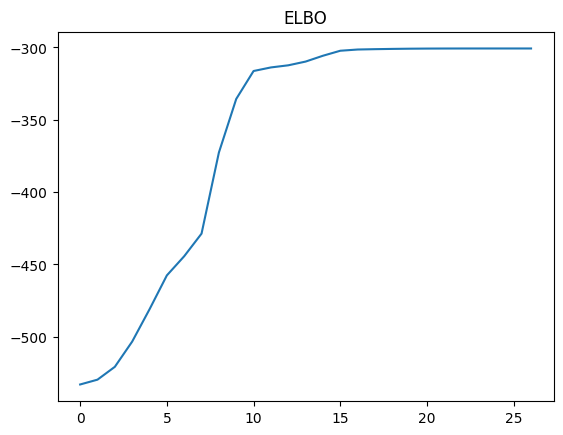

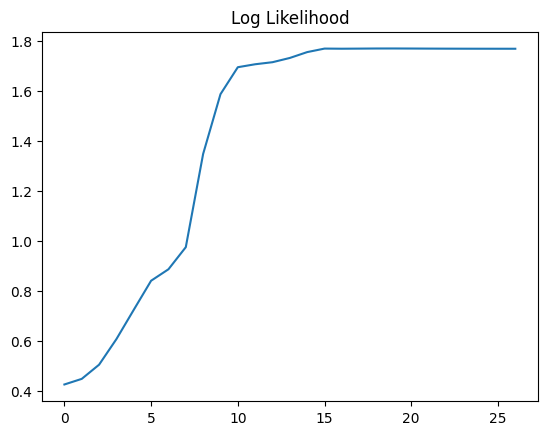

In [1119]:
R, Σs, ms, x_hats, x_hats_outer, α, Vks, loglikes,elbos = meanfield_vi(X_train,3, mode=0)
zs = np.argmax(R, axis=1)
print(metrics.adjusted_rand_score(y_train, zs))
plt.plot(elbos)
plt.title("ELBO")
plt.show()
plt.plot(loglikes)
plt.title("Log Likelihood")
plt.show()

In [737]:
import random
N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

0.6202205420880726


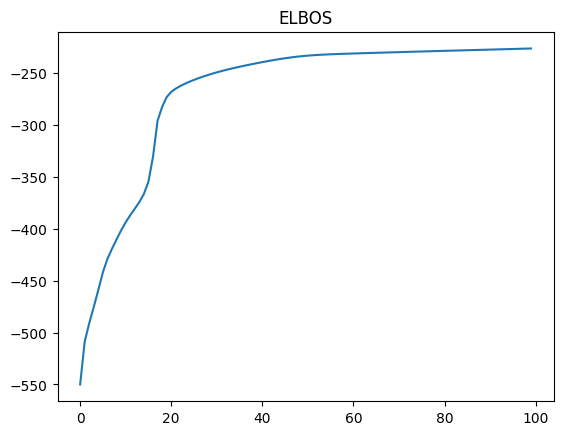

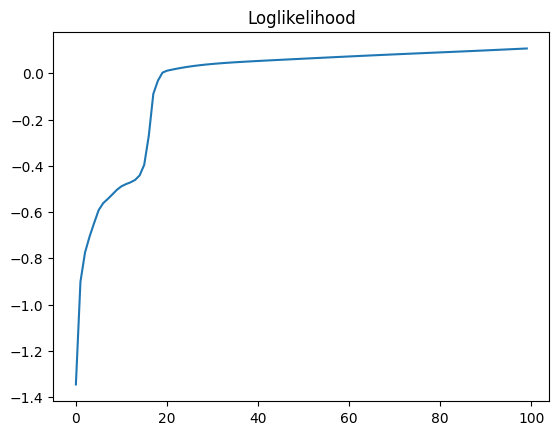

In [1114]:
R, Σs, ms, x_hats, x_hats_outer, α, Vks, loglikes, elbos = meanfield_vi(X_cover1,3)
zs = np.argmax(R, axis=1)
print(metrics.adjusted_rand_score(y_train, zs))
plt.plot(elbos)
plt.title("ELBOS")
plt.show()

plt.plot(loglikes)
plt.title("Loglikelihood")
plt.show()

## 3.2 Penguin Dataset

In [469]:
dirpath = "./../../Datasets/Gaussian/Processed/penguin/"
X_train = np.load(dirpath + "X_train_penguin.npy")
y_train = np.load(dirpath + "y_train_penguin.npy")

0.9410120493018651


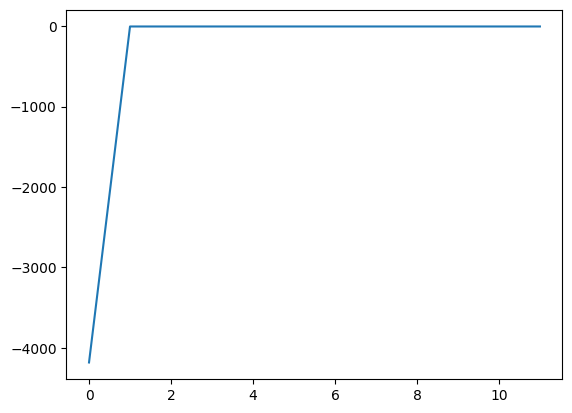

In [91]:
R, Σs, ms, x_hats, x_hats_outer, α, Vks, loglikes = meanfield_vi(X_train,3)
zs = np.argmax(R, axis=1)
print(metrics.adjusted_rand_score(y_train, zs))
plt.plot(loglikes)
plt.show()

In [470]:
import random
N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

0.6701844266965312


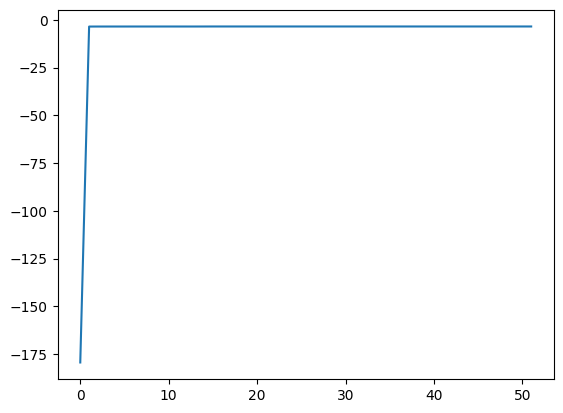

In [471]:
R, Σs, ms, x_hats, x_hats_outer, α, Vks, loglikes = meanfield_vi(X_train,3)
zs = np.argmax(R, axis=1)
print(metrics.adjusted_rand_score(y_train, zs))
plt.plot(loglikes)
plt.show()

# Appendix

## 1 Conditional Derivation of X_H

Let 
$$
    \mathbf{x}^n | z_n=k \sim \mathcal{N}(\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)
$$
Where
$$\begin{align}
    & \mathbf{x}^n = \begin{bmatrix}\mathbf{x}^n_O \\  \mathbf{x}^n_H\end{bmatrix} \quad
      \boldsymbol{\mu}_k = \begin{bmatrix} \boldsymbol{\mu}_k^O \\ \boldsymbol{\mu}_k^H \end{bmatrix} \quad 
      \boldsymbol{\Sigma}_k = \begin{bmatrix} 
                                    \boldsymbol{\Sigma}_k^{OO} & \boldsymbol{\Sigma}_k^{OH}\\
                                    \boldsymbol{\Sigma}_k^{HO} & \boldsymbol{\Sigma}_k^{HH}
                              \end{bmatrix}
\end{align}$$
Then the quadratic term of $\mathcal{N}(\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)$ becomes:

$$\begin{align}
    -\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k) &= 
            -\frac{1}{2} \begin{bmatrix} 
                \mathbf{x}^n_O - \boldsymbol{\mu}_k^O\\
                \mathbf{x}^n_H - \boldsymbol{\mu}_k^H
            \end{bmatrix}^T \begin{bmatrix}
                \boldsymbol{\Lambda}_k^{OO} & \boldsymbol{\Lambda}_k^{OH}\\
                \boldsymbol{\Lambda}_k^{HO} & \boldsymbol{\Lambda}_k^{HH}
            \end{bmatrix} \begin{bmatrix} 
                \mathbf{x}^n_O - \boldsymbol{\mu}_k^O\\
                \mathbf{x}^n_H - \boldsymbol{\mu}_k^H
            \end{bmatrix}\\\\
        
        &= -\frac{1}{2}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O)^T\boldsymbol{\Lambda}_k^{OO}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O)
           -\frac{1}{2}(\mathbf{x}^n_H - \boldsymbol{\mu}_k^H)^T\boldsymbol{\Lambda}_k^{HH}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^H)
           - (\mathbf{x}^n_H - \boldsymbol{\mu}_k^H)^T\boldsymbol{\Lambda}_k^{HO}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^O)
\end{align}$$

## ELBO Components 


### $\mathbb{KL}(p(\mu,\Sigma) || q(\mu))$
$$\begin{align}
    \Big\langle \sum_k^K \log p(\boldsymbol{\mu}_k|\boldsymbol{\Sigma}_k) \Big\rangle_{q(\mu)} &=\\
        &=  \sum_k^K \Big\langle  \mathcal{N}(\boldsymbol{\mu}_k \mid \mathbf{m}_{0}, \boldsymbol{\Lambda}_k)  \Big\rangle_{q(\mu)}, \quad \boldsymbol{\Lambda}_k = \frac{1}{\kappa_0}\boldsymbol{\hat{\Sigma}}_k \\

        &=  \sum_k^K \Big\langle 
                -\frac{D}{2}\log(2\boldsymbol{\pi}) - \frac{1}{2}\log|\boldsymbol{\Lambda}_k|  
                - \frac{1}{2}(\boldsymbol{\mu}_k - \mathbf{m}_0)^T\boldsymbol{\Lambda}_k^{-1}(\boldsymbol{\mu}_k - \mathbf{m}_0)
            \Big\rangle_{q(\mu)} \\

        &=  - \frac{1}{2} \sum_k^K \Big\langle   
                D\log(2\boldsymbol{\pi}) + \log|\boldsymbol{\Lambda}_k|  
                + \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k^{-1} \boldsymbol{\mu}_k 
                - 2 \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
                + \mathbf{m}_0^T\boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
            \Big\rangle_{q(\mu)} \\

        &=  - \frac{1}{2}\sum_k^K \Bigg[ 
                (\cdots) 
                + \Big\langle \text{tr}\big( \boldsymbol{\mu}_k^T\boldsymbol{\Lambda}_k^{-1} \boldsymbol{\mu}_k \big) \Big\rangle_{q(\mu)}
                - 2 \Big\langle \boldsymbol{\mu}_k \Big\rangle_{q(\mu)}^T \boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
                + \mathbf{m}_0^T\boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
            \Bigg]\\

        &=  - \frac{1}{2}\sum_k^K \Bigg[ 
                (\cdots) 
                + \Big\langle \text{tr}\big(\boldsymbol{\Lambda}_k^{-1} \boldsymbol{\mu}_k\boldsymbol{\mu}_k^T \big) \Big\rangle_{q(\mu)}
                - 2 \Big\langle \boldsymbol{\mu}_k \Big\rangle_{q(\mu)}^T \boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
                + \mathbf{m}_0^T\boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
            \Bigg]\\

        &=  - \frac{1}{2}\sum_k^K \Bigg[ 
                (\cdots) 
                +  \text{tr}\Big(\boldsymbol{\Lambda}_k^{-1} \big\langle \boldsymbol{\mu}_k\boldsymbol{\mu}_k^T \big\rangle_{q(\mu)} \Big) 
                - 2 \Big\langle \boldsymbol{\mu}_k \Big\rangle_{q(\mu)}^T \boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
                + \mathbf{m}_0^T\boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
            \Bigg]\\

        &=  - \frac{1}{2}\sum_k^K \Bigg[ 
                (\cdots) 
                +  \text{tr}\Big(\boldsymbol{\Lambda}_k^{-1} \big( \mathbf{m}_k\mathbf{m}_k^T +  \mathbf{V}_k \big) \Big) 
                - 2 \mathbf{m}_k^T \boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
                + \mathbf{m}_0^T\boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
            \Bigg], \quad \text{where } \boldsymbol{\mu}_k \sim \mathcal{N}(\mathbf{m}_k, \mathbf{V}_k)\\

        &= - \frac{1}{2}\sum_k^K \Bigg[ 
                (\cdots) 
                +  \text{tr}\Big(\boldsymbol{\Lambda}_k^{-1}\mathbf{m}_k\mathbf{m}_k^T +  \boldsymbol{\Lambda}_k^{-1}\mathbf{V}_k \Big) 
                - 2 \mathbf{m}_k^T \boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
                + \mathbf{m}_0^T\boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
            \Bigg]\\

        &= - \frac{1}{2}\sum_k^K \Bigg[ 
                (\cdots) 
                +  \text{tr}\Big(\boldsymbol{\Lambda}_k^{-1}\mathbf{m}_k\mathbf{m}_k^T\Big) 
                +  \text{tr}\Big(\boldsymbol{\Lambda}_k^{-1}\mathbf{V}_k \Big) 
                - 2 \mathbf{m}_k^T \boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
                + \mathbf{m}_0^T\boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
            \Bigg]\\

        &= - \frac{1}{2}\sum_k^K \Bigg[ 
                (\cdots) 
                +  \mathbf{m}_k^T \boldsymbol{\Lambda}_k^{-1}\mathbf{m}_k
                +  \text{tr}\Big(\boldsymbol{\Lambda}_k^{-1}\mathbf{V}_k \Big) 
                - 2 \mathbf{m}_k^T \boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
                + \mathbf{m}_0^T\boldsymbol{\Lambda}_k^{-1}\mathbf{m}_0
            \Bigg]\\

        &= - \frac{1}{2}\sum_k^K \Bigg[ 
                D\log(2\boldsymbol{\pi}) + \log|\boldsymbol{\Lambda}_k|
                +  \text{tr}\Big(\boldsymbol{\Lambda}_k^{-1}\mathbf{V}_k \Big) 
                + (\mathbf{m}_k - \mathbf{m}_0)^T \boldsymbol{\Lambda}_k^{-1}(\mathbf{m}_k - \mathbf{m}_0)
            \Bigg]\\
\end{align}$$

$$\begin{align}
    \sum_k^K \log p(\boldsymbol{\hat{\Sigma}}_k) &= \sum_k^K \log \mathcal{NIW}(\boldsymbol{\hat{\Sigma}}_k \mid \mathbf{S}_0, \nu_0)\\
\end{align}$$

$$\begin{align}
    \Big\langle \sum_k^K \log q(\boldsymbol{\mu}_k) \Big\rangle_{q(\mu)} &= \\\\

    &= \sum_k^K \Big\langle  \log \mathcal{N}(\boldsymbol{\mu}_k \mid \mathbf{m}_k, \mathbf{V}_k) \Big\rangle_{q(\mu)} \\\\

    &= \sum_k^K \Big\langle 
            -\frac{D}{2} \log 2\pi - \frac{1}{2}\log|\mathbf{V}_k|
            - \frac{1}{2}(\boldsymbol{\mu}_k - \mathbf{m}_k)^T \mathbf{V}_k^{-1} (\boldsymbol{\mu}_k - \mathbf{m}_k) 
        \Big\rangle_{q(\mu)} \\ \\

    &= -\frac{1}{2}\sum_k^K \Big\langle 
            D\log 2\pi + \log |\mathbf{V}_k|
            + \boldsymbol{\mu}_k^T\mathbf{V}_k^{-1}\boldsymbol{\mu}_k
            -2\boldsymbol{\mu}_k^T\mathbf{V}_k^{-1}\mathbf{m}_k
            + \mathbf{m}_k^T\mathbf{V}_k^{-1}\mathbf{m}_k
        \Big\rangle_{q(\mu)} \\ \\

    &= -\frac{1}{2}\sum_k^K \Bigg[ 
            (\cdots)
            + \Big\langle \text{tr}\Big(\boldsymbol{\mu}_k^T\mathbf{V}_k^{-1}\boldsymbol{\mu}_k\Big)\Big\rangle_{q(\mu)}
            -2\Big\langle\boldsymbol{\mu}_k\Big\rangle_{q(\mu)}^T\mathbf{V}_k^{-1}\mathbf{m}_k
            + \mathbf{m}_k^T\mathbf{V}_k^{-1}\mathbf{m}_k
        \Bigg]\\\\
    
    &= -\frac{1}{2}\sum_k^K \Bigg[ 
            (\cdots)
            + \text{tr}\Big(\mathbf{V}_k^{-1}\big\langle\boldsymbol{\mu}_k\boldsymbol{\mu}_k^T\big\rangle_{q(\mu)}\Big)
            -2\Big\langle\boldsymbol{\mu}_k\Big\rangle_{q(\mu)}^T\mathbf{V}_k^{-1}\mathbf{m}_k
            + \mathbf{m}_k^T\mathbf{V}_k^{-1}\mathbf{m}_k
        \Bigg]\\\\

    &= -\frac{1}{2}\sum_k^K \Bigg[ 
            (\cdots)
            + \text{tr}\Big(\mathbf{V}_k^{-1}\big( \mathbf{m}_k\mathbf{m}_k^T + \mathbf{V}_k \big)\Big)
            -2\mathbf{m}_k^T\mathbf{V}_k^{-1}\mathbf{m}_k
            + \mathbf{m}_k^T\mathbf{V}_k^{-1}\mathbf{m}_k
        \Bigg], \quad \text{since } \boldsymbol{\mu}_k \sim \mathcal{N}(\boldsymbol{\mu}_k \mid \mathbf{m}_k, \mathbf{V}_k)\\\\


    &= -\frac{1}{2}\sum_k^K \Bigg[ 
            (\cdots)
            + \text{tr}\Big(\mathbf{V}_k^{-1}\mathbf{m}_k\mathbf{m}_k^T + \mathbf{V}_k^{-1}\mathbf{V}_k \Big)
            - \mathbf{m}_k^T\mathbf{V}_k^{-1}\mathbf{m}_k
        \Bigg]\\\\

    &= -\frac{1}{2}\sum_k^K \Bigg[ 
            (\cdots)
            + \mathbf{m}_k^T\mathbf{V}_k^{-1}\mathbf{m}_k + D 
            - \mathbf{m}_k^T\mathbf{V}_k^{-1}\mathbf{m}_k
        \Bigg]\\\\

    &= -\frac{1}{2}\sum_k^K \Bigg[ 
            D\log 2\pi + \log |\mathbf{V}_k| + D 
        \Bigg]\\\\
\end{align}$$



### $\mathbb{KL}(p(\mathbf{X}_O,\mathbf{X}_H) || q(\mathbf{X}_H))$

$$\begin{align}
    \Big\langle \sum_n^N \sum_k^K r_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) \Big\rangle_{q(X_H,\mu)} &=\\\\

    &=   \sum_n^N \sum_k^K r_{nk} \Big\langle \log \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k)\Big\rangle_{q(X_H,\mu)}\\\\

    &= -\frac{1}{2}\sum_n^N \sum_k^K r_{nk} \Big\langle
            D\log 2\pi + \log|\boldsymbol{\hat{\Sigma}}_k| + (\mathbf{x_n} - \boldsymbol{\mu}_k)^T\boldsymbol{\hat{\Sigma}}_k^{-1}(\mathbf{x_n} - \boldsymbol{\mu}_k)
        \Big\rangle_{q(X_H,\mu)}\\\\

    &= -\frac{1}{2}\sum_n^N \sum_k^K r_{nk} \Big\langle
            D\log 2\pi + \log|\boldsymbol{\hat{\Sigma}}_k| + 
            \mathbf{x_n}^T\boldsymbol{\hat{\Sigma}}_k^{-1}\mathbf{x_n} 
            -2\mathbf{x_n}^T\boldsymbol{\hat{\Sigma}}_k^{-1}\boldsymbol{\mu}_k
            +\boldsymbol{\mu}_k^T \boldsymbol{\hat{\Sigma}}_k^{-1} \boldsymbol{\mu}_k
        \Big\rangle_{q(X_H,\mu)}\\\\

    &= -\frac{1}{2}\sum_n^N \sum_k^K r_{nk} \Bigg[
            D\log 2\pi + \log|\boldsymbol{\hat{\Sigma}}_k| + 
            \Big\langle\text{tr}\big(\mathbf{x_n}^T\boldsymbol{\hat{\Sigma}}_k^{-1}\mathbf{x_n} \big) \Big\rangle_{q(X_H)}
            -2 \Big\langle \mathbf{x_n}\Big\rangle_{q(X_H)}^T\boldsymbol{\hat{\Sigma}}_k^{-1}\Big\langle\boldsymbol{\mu}_k\Big\rangle_{q(\mu)}
            \Big\langle\text{tr}\big(\boldsymbol{\mu}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\boldsymbol{\mu}_k \big) \Big\rangle_{q(\mu)}
        \Bigg]\\\\

    &= -\frac{1}{2}\sum_n^N \sum_k^K r_{nk} \Bigg[
            D\log 2\pi + \log|\boldsymbol{\hat{\Sigma}}_k| + 
            \text{tr}\Big(\boldsymbol{\hat{\Sigma}}_k^{-1}\big\langle \mathbf{x_n}\mathbf{x_n}^T \big\rangle_{q(X_H)} \Big) 
            -2 \Big\langle \mathbf{x_n}\Big\rangle_{q(X_H)}^T\boldsymbol{\hat{\Sigma}}_k^{-1}\mathbf{m}_k
            + \text{tr}\Big(\boldsymbol{\hat{\Sigma}}_k^{-1}\big\langle\boldsymbol{\mu}_k\boldsymbol{\mu}_k^T \big\rangle_{q(\mu)} \Big) 
        \Bigg]\\\\

    &= -\frac{1}{2}\sum_n^N \sum_k^K r_{nk} \Bigg[
            D\log 2\pi + \log|\boldsymbol{\hat{\Sigma}}_k| + 
            \text{tr}\Big(\boldsymbol{\hat{\Sigma}}_k^{-1}\big\langle \mathbf{x_n}\mathbf{x_n}^T \big\rangle_{q(X_H)} \Big) 
            -2 \Big\langle \mathbf{x_n}\Big\rangle_{q(X_H)}^T\boldsymbol{\hat{\Sigma}}_k^{-1}\mathbf{m}_k
            + \text{tr}\Big(\boldsymbol{\hat{\Sigma}}_k^{-1} ( \mathbf{m}_k\mathbf{m}_k^T + \mathbf{V}_k ) \Big) 
        \Bigg]\\\\

    &= -\frac{1}{2}\sum_n^N \sum_k^K r_{nk} \Bigg[
            D\log 2\pi + \log|\boldsymbol{\hat{\Sigma}}_k| + 
            \text{tr}\Big(\boldsymbol{\hat{\Sigma}}_k^{-1}\big\langle \mathbf{x_n}\mathbf{x_n}^T \big\rangle_{q(X_H)} \Big) 
            -2 \Big\langle \mathbf{x_n}\Big\rangle_{q(X_H)}^T\boldsymbol{\hat{\Sigma}}_k^{-1}\mathbf{m}_k
            + \text{tr}\Big(\boldsymbol{\hat{\Sigma}}_k^{-1}\mathbf{m}_k\mathbf{m}_k^T + \boldsymbol{\hat{\Sigma}}_k^{-1}\frac{\boldsymbol{\Sigma}_k}{N_k + \kappa_0}  \Big) 
        \Bigg]\\\\

    &= -\frac{1}{2}\sum_n^N \sum_k^K r_{nk} \Bigg[
            D\log 2\pi + \log|\boldsymbol{\hat{\Sigma}}_k| + 
            \text{tr}\Big(\boldsymbol{\hat{\Sigma}}_k^{-1}\big\langle \mathbf{x_n}\mathbf{x_n}^T \big\rangle_{q(X_H)} \Big) 
            -2 \Big\langle \mathbf{x_n}\Big\rangle_{q(X_H)}^T\boldsymbol{\hat{\Sigma}}_k^{-1}\mathbf{m}_k
            + \text{tr}\Big(\boldsymbol{\hat{\Sigma}}_k^{-1}\mathbf{m}_k\mathbf{m}_k^T \Big) + \text{tr}\Big(I\frac{1}{N_k + \kappa_0}  \Big) 
        \Bigg]\\\\

    &= -\frac{1}{2}\sum_n^N \sum_k^K r_{nk} \Bigg[
            D\log 2\pi + \log|\boldsymbol{\hat{\Sigma}}_k| + 
            \text{tr}\Big(\boldsymbol{\hat{\Sigma}}_k^{-1}\big\langle \mathbf{x_n}\mathbf{x_n}^T \big\rangle_{q(X_H)} \Big) 
            -2 \Big\langle \mathbf{x_n}\Big\rangle_{q(X_H)}^T\boldsymbol{\hat{\Sigma}}_k^{-1}\mathbf{m}_k
            + \mathbf{m}_k^T\boldsymbol{\hat{\Sigma}}_k^{-1}\mathbf{m}_k
            + \frac{D}{N_k + \kappa_0}  
        \Bigg]\\\\
\end{align}$$



$$\begin{align}
    \Big\langle \sum_n^N  \log q(\mathbf{x}^n_H) \Big\rangle_{q(X_H)} &=\\\\

    &= \sum_n^N  \Big\langle r_{nk} \log \mathcal{N}(\mathbf{x}^n_H \mid \mathbf{m}_{nk}^{H|O}, \mathbf{V}_k^{H|O})  \Big\rangle_{q(X_H)}\\\\

    &= -\frac{r_{nk}}{2} \sum_n^N \Big\langle
            D_H^{nk}\log 2\pi + \log|\mathbf{V}_k^{H|O}| 
            + (\mathbf{x}^n_H - \mathbf{m}_{nk}^{H|O})^T {\mathbf{V}_k^{H|O}}^{-1}(\mathbf{x}^n_H - \mathbf{m}_{nk}^{H|O})
        \Big\rangle_{q(X_H)}\\\\

    &= -\frac{r_{nk}}{2} \sum_n^N \Big\langle
            D_H^{nk}\log 2\pi + \log|\mathbf{V}_k^{H|O}| 
            + {\mathbf{x}^n_H}^T{\mathbf{V}_k^{H|O}}^{-1}{\mathbf{x}^n_H}
            - 2{\mathbf{x}^n_H}^T{\mathbf{V}_k^{H|O}}^{-1}{\mathbf{m}_{nk}^{H|O}}
            +{\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}{\mathbf{m}_{nk}^{H|O}}
        \Big\rangle_{q(X_H)}\\\\

    &= -\frac{r_{nk}}{2} \sum_n^N \Big[
            \cdots 
            + \Big\langle\text{tr}({\mathbf{V}_k^{H|O}}^{-1}{\mathbf{x}^n_H}{\mathbf{x}^n_H}^T)\Big\rangle_{q(X_H)}
            - 2\Big\langle{\mathbf{x}^n_H}\Big\rangle_{q(X_H)}^T{\mathbf{V}_k^{H|O}}^{-1}{\mathbf{m}_{nk}^{H|O}}
            +{\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}{\mathbf{m}_{nk}^{H|O}}
        \Big]\\\\

    &= -\frac{r_{nk}}{2} \sum_n^N \Big[
            \cdots 
            + \text{tr}\Big({\mathbf{V}_k^{H|O}}^{-1}\big\langle{\mathbf{x}^n_H}{\mathbf{x}^n_H}^T\big\rangle_{q(X_H)}\Big)
            - 2\Big\langle{\mathbf{x}^n_H}\Big\rangle_{q(X_H)}^T{\mathbf{V}_k^{H|O}}^{-1}{\mathbf{m}_{nk}^{H|O}}
            +{\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}{\mathbf{m}_{nk}^{H|O}}
        \Big]\\\\

    &= -\frac{r_{nk}}{2} \sum_n^N \Big[
            \cdots 
            + \text{tr}\Big({\mathbf{V}_k^{H|O}}^{-1}\big( {\mathbf{m}_{nk}^{H|O}}{\mathbf{m}_{nk}^{H|O}}^T + {\mathbf{V}_k^{H|O}} \big)\Big)
            - 2{\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}{\mathbf{m}_{nk}^{H|O}}
            +{\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}{\mathbf{m}_{nk}^{H|O}}
        \Big]\\\\

    &= -\frac{r_{nk}}{2} \sum_n^N \Big[
            \cdots 
            + \text{tr}\Big({\mathbf{V}_k^{H|O}}^{-1}{\mathbf{m}_{nk}^{H|O}}{\mathbf{m}_{nk}^{H|O}}^T + I_H \Big)
            - {\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}{\mathbf{m}_{nk}^{H|O}}
        \Big]\\\\

    &= -\frac{r_{nk}}{2} \sum_n^N \Big[
            \cdots 
            + {\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}{\mathbf{m}_{nk}^{H|O}} + D_H
            - {\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}{\mathbf{m}_{nk}^{H|O}}
        \Big]\\\\

    &= -\frac{r_{nk}}{2} \sum_n^N \Big[
            D_H^{nk}\log 2\pi + \log|\mathbf{V}_k^{H|O}| + D_H
        \Big]\\\\
\end{align}$$

#### $\mathbb{KL}(q(\pi) || p(\pi))$

$$\begin{align}
    \Big\langle \log p(\boldsymbol{\pi}) \Big\rangle_{q(\pi)} - \Big\langle \log q(\boldsymbol{\pi}) \Big\rangle_{q(\pi)} &=\\\\

    &= \Big\langle \log \mathrm{Dir}(\boldsymbol{\pi} \mid \boldsymbol{\alpha_0}) \Big\rangle_{q(\pi)}
       - \Big\langle \log \mathrm{Dir}(\boldsymbol{\pi} \mid \boldsymbol{\alpha}) \Big\rangle_{q(\pi)}\\\\

    &= \Big\langle \log \big[ \frac{1}{B(\boldsymbol{\alpha_0})} \prod_k^K \pi_k^{\alpha_{0,k} - 1}\big] \Big\rangle_{q(\pi)}
       - \Big\langle \log \big[ \frac{1}{B(\boldsymbol{\alpha})} \prod_k^K \pi_k^{\alpha_{k} - 1}\big] \Big\rangle_{q(\pi)}\\\\

    &= \Big\langle - \log B(\boldsymbol{\alpha_0})  + \sum_k^K (\alpha_{0,k} - 1) \log \pi_k\Big\rangle_{q(\pi)}
      - \Big\langle - \log B(\boldsymbol{\alpha})  + \sum_k^K (\alpha_{k} - 1) \log \pi_k\Big\rangle_{q(\pi)}\\\\

    &= - \log B(\boldsymbol{\alpha_0})  + \sum_k^K (\alpha_{0,k} - 1) \Big\langle \log \pi_k \Big\rangle_{q(\pi)}
        + \log B(\boldsymbol{\alpha})  + \sum_k^K (\alpha_{k} - 1) \Big\langle \log \pi_k \Big\rangle_{q(\pi)}\\\\

    &= - \log B(\boldsymbol{\alpha_0})  + \sum_k^K (\alpha_{0,k} - 1) \Big[ \psi(\alpha_{k}) - \psi(\sum_j^K \alpha_{j}) \Big]
        + \log B(\boldsymbol{\alpha})  - \sum_k^K (\alpha_{k} - 1) \Big[ \psi(\alpha_{k}) - \psi(\sum_j^K \alpha_j) \Big]\\\\

    &= \log B(\boldsymbol{\alpha}) - \log B(\boldsymbol{\alpha_0}) +
        \sum_k^K \Bigg[ 
            (\alpha_{0,k} - 1)\Big( \psi(\alpha_{k}) - \psi(\sum_j^K \alpha_{j}) \Big) 
            - (\alpha_{k} - 1)\Big[ \psi(\alpha_{k}) - \psi(\sum_j^K \alpha_j) \Big]
        \Bigg]\\\\

    &= \log B(\boldsymbol{\alpha}) - \log B(\boldsymbol{\alpha_0}) +
        \sum_k^K \Bigg[ 
            (\alpha_{0,k} - \alpha_k)\Big( \psi(\alpha_{k}) - \psi(\sum_j^K \alpha_{j}) \Big) 
        \Bigg]
\end{align}$$

#### $\mathbb{KL}(q(z) || p(z|\pi))$

$$\begin{align}
    \Big\langle \log p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(z,\pi)} - \Big\langle \log q(\mathbf{z}) \Big\rangle_{q(z,\pi)} &= \\\\

    &= \Big\langle \sum_n^N \sum_k^K z_{nk} \log \pi_k\Big\rangle_{q(\pi)q(z)}
        - \Big\langle \sum_n^N \sum_k^K z_{nk} \log r_{nk} \Big\rangle_{q(z)}\\\\

    &= \sum_n^N \sum_k^K \Big\langle z_{nk} \Big\rangle_{q(z)}  \Big\langle \log \pi_k \Big\rangle_{q(\pi)}
       - \sum_n^N \sum_k^K \Big\langle z_{nk}\Big\rangle_{q(z)} \log r_{nk}\\\\

    &= \sum_n^N \sum_k^K r_{nk} \Big( \psi(\alpha_k) - \psi(\sum_j^K \alpha_j) \Big)
       - \sum_n^N \sum_k^K r_{nk} \log r_{nk}\\\\
\end{align}$$

--- 

Expected data loglikelihood but marginalized

$$\begin{align}
    \Big\langle \sum_n^N \sum_k^K r_{nk} \log p(\mathbf{x}^n_O,\mathbf{x}^n_H \mid \boldsymbol{\mu}_k,\boldsymbol{\hat{\Sigma}}_k) \Big\rangle_{q(X_H,\mu)} &=\\\\

    &= \sum_n^N \sum_k^K r_{nk} \Big\langle 
            \log p(\mathbf{x}^n_O \mid \boldsymbol{\mu}_k^O,\boldsymbol{\Sigma}_k^{OO}) + 
            \log p(\mathbf{X}_H \mid \mathbf{m}_{nk}^{H|O}, \mathbf{V}_k^{H|O}) 
        \Big\rangle_{q(X_H,\mu)}\\\\

    &= \sum_n^N \sum_k^K r_{nk} \Big\langle
            \log \mathcal{N}(\mathbf{x}^n_O \mid \boldsymbol{\mu}_k^O,\boldsymbol{\Sigma}_k^{OO})
            + \log \mathcal{N}(\mathbf{X}_H \mid \mathbf{m}_{nk}^{H|O}, \mathbf{V}_k^{H|O})
        \Big\rangle_{q(X_H,\mu)}\\\\

    &= \sum_n^N \sum_k^K -\frac{r_{nk}}{2} \Bigg\langle
            D_O\log 2\pi + \log|\boldsymbol{\hat{\Sigma}}^{OO}_k| + (\mathbf{x}^n_O - \boldsymbol{\mu}_k^{O})^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}(\mathbf{x}^n_O - \boldsymbol{\mu}_k^{O})\\

            &\qquad\qquad + D_H\log 2\pi + \log|\mathbf{V}_k^{H|O}| + (\mathbf{x}^n_H - \mathbf{m}_{nk}^{H|O})^T {\mathbf{V}_k^{H|O}}^{-1} (\mathbf{x}^n_H - \mathbf{m}_{nk}^{H|O})
        \Bigg\rangle_{q(X_H,\mu)}\\\\

    &= \sum_n^N \sum_k^K -\frac{r_{nk}}{2} \Bigg\langle
            (\cdots) 
            + {\mathbf{x}^n_O}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}{\mathbf{x}^n_O} - 2{\mathbf{x}^n_O}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}\boldsymbol{\mu}_k^{O} + {\boldsymbol{\mu}_k^{O}}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}{\boldsymbol{\mu}_k^{O}} +\\

            &\qquad\qquad {\mathbf{x}^n_H}^T{\mathbf{V}_k^{H|O}}^{-1}{\mathbf{x}^n_H} - 2{\mathbf{x}^n_H}^T{\mathbf{V}_k^{H|O}}^{-1}\mathbf{m}_{nk}^{H|O} + {\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}\mathbf{m}_{nk}^{H|O}
        \Bigg\rangle_{q(X_H,\mu)}\\\\

    &= \sum_n^N \sum_k^K -\frac{r_{nk}}{2} \Bigg[
            (\cdots) 
            + {\mathbf{x}^n_O}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}{\mathbf{x}^n_O} 
                - 2{\mathbf{x}^n_O}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}\Big\langle\boldsymbol{\mu}_k^{O}\Big\rangle_{q(\mu)} 
                + \Big\langle\text{tr}\big({\boldsymbol{\mu}_k^{O}}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}{\boldsymbol{\mu}_k^{O}}\big)\Big\rangle_{q(\mu)} +\\

            &\qquad\qquad \Big\langle\text{tr}\big({\mathbf{x}^n_H}^T{\mathbf{V}_k^{H|O}}^{-1}{\mathbf{x}^n_H}\big) \Big\rangle_{q(X_H)}
            - 2\big\langle{\mathbf{x}^n_H}\big\rangle_{q(X_H)}^T{\mathbf{V}_k^{H|O}}^{-1}\mathbf{m}_{nk}^{H|O}
            + {\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}\mathbf{m}_{nk}^{H|O}
        \Bigg]\\\\

    &= \sum_n^N \sum_k^K -\frac{r_{nk}}{2} \Bigg[
            (\cdots) 
            + {\mathbf{x}^n_O}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}{\mathbf{x}^n_O} 
                - 2{\mathbf{x}^n_O}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}\Big\langle\boldsymbol{\mu}_k^{O}\Big\rangle_{q(\mu)} 
                + \text{tr}\Big({\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}\langle{\boldsymbol{\mu}_k^{O}}{\boldsymbol{\mu}_k^{O}}^T\rangle_{q(\mu)} \Big)+\\

            &\qquad\qquad \text{tr}\Big({\mathbf{V}_k^{H|O}}^{-1}\langle{\mathbf{x}^n_H}{\mathbf{x}^n_H}^T\rangle_{q(X_H)}\Big) 
            - 2\big\langle{\mathbf{x}^n_H}\big\rangle_{q(X_H)}^T{\mathbf{V}_k^{H|O}}^{-1}\mathbf{m}_{nk}^{H|O}
            + {\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}\mathbf{m}_{nk}^{H|O}
        \Bigg]\\\\

    &= \sum_n^N \sum_k^K -\frac{r_{nk}}{2} \Bigg[
            (\cdots) 
            + {\mathbf{x}^n_O}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}{\mathbf{x}^n_O} 
                - 2{\mathbf{x}^n_O}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}\mathbf{m}_k^O
                + \text{tr}\Big({\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}({\mathbf{m}_k^{O}}{\mathbf{m}_k^{O}}^T + \frac{1}{\kappa_0}\boldsymbol{\hat{\Sigma}}^{OO}_k) \Big)+\\

            &\qquad\qquad \text{tr}\Big({\mathbf{V}_k^{H|O}}^{-1}({\mathbf{m}_{nk}^{H|O}}{\mathbf{m}_{nk}^{H|O}}^T + {\mathbf{V}_k^{H|O}})\Big) 
            - 2{\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}\mathbf{m}_{nk}^{H|O}
            + {\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}\mathbf{m}_{nk}^{H|O}
        \Bigg]\\\\

    &= \sum_n^N \sum_k^K -\frac{r_{nk}}{2} \Bigg[
            (\cdots) 
            + {\mathbf{x}^n_O}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}{\mathbf{x}^n_O} 
                - 2{\mathbf{x}^n_O}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}\mathbf{m}_k^O
                + \text{tr}\Big({\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}{\mathbf{m}_k^{O}}{\mathbf{m}_k^{O}}^T + \frac{1}{\kappa_0}I_O\Big)+\\

            &\qquad\qquad \text{tr}\Big({\mathbf{V}_k^{H|O}}^{-1}{\mathbf{m}_{nk}^{H|O}}{\mathbf{m}_{nk}^{H|O}}^T + I_H\Big) 
            - 2{\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}\mathbf{m}_{nk}^{H|O}
            + {\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}\mathbf{m}_{nk}^{H|O}
        \Bigg]\\\\

     &= \sum_n^N \sum_k^K -\frac{r_{nk}}{2} \Bigg[
            (\cdots) 
            + {\mathbf{x}^n_O}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}{\mathbf{x}^n_O} 
                - 2{\mathbf{x}^n_O}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}\mathbf{m}_k^O
                + {\mathbf{m}_k^{O}}^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}{\mathbf{m}_k^{O}} + \frac{1}{\kappa_0}D_O +\\

            &\qquad\qquad {\mathbf{m}_{nk}^{H|O}}^T {\mathbf{V}_k^{H|O}}^{-1}{\mathbf{m}_{nk}^{H|O}} + D_H + 
            - 2{\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}\mathbf{m}_{nk}^{H|O}
            + {\mathbf{m}_{nk}^{H|O}}^T{\mathbf{V}_k^{H|O}}^{-1}\mathbf{m}_{nk}^{H|O}
        \Bigg]\\\\

    &= \sum_n^N \sum_k^K -\frac{r_{nk}}{2} \Bigg[
            (\cdots) 
            + (\mathbf{x}^n_O - \mathbf{m}_k^{O})^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}(\mathbf{x}^n_O - \mathbf{m}_k^{O}) + \frac{1}{\kappa_0}D_O + D_H 
        \Bigg]\\\\

    &= \sum_n^N \sum_k^K -\frac{r_{nk}}{2} \Bigg[
            D_O\log 2\pi + \log|\boldsymbol{\hat{\Sigma}}^{OO}_k| + D_H\log 2\pi + \log|\mathbf{V}_k^{H|O}| 
            + (\mathbf{x}^n_O - \mathbf{m}_k^{O})^T{\boldsymbol{\hat{\Sigma}}^{OO}_k}^{-1}(\mathbf{x}^n_O - \mathbf{m}_k^{O}) + \frac{1}{\kappa_0}D_O + D_H 
        \Bigg]\\\\
\end{align}$$